In [2]:
import scanpy as sc

import cellbin_moran as cm

import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

AttributeError: module 'anndata' has no attribute '_core'

In [ ]:
def plot_normalized_umap_single(
    adata,
    cell_type: str = "Micro",
    color: str = "min_center_dist",
    palette: dict = None,
    ax=None,
    **umap_kwargs
) -> plt.Axes:
    """
    Plots a UMAP projection with normalized values for the given AnnData object.

    Args:
        adata: The AnnData object.
        cell_type: The cell type to filter on for plotting. If None, plot all cells.
        color: The column name in `adata.obs` to normalize and plot.
        palette: Optional dictionary specifying the color palette to use if 'color' is categorical.
        ax: The axis to plot on. If None, a new figure and axis will be created.
        **umap_kwargs: Arbitrary keyword arguments to pass to the `sc.pl.umap` function.

    Returns:
        plt.Axes: The matplotlib axes object.
    """
    def normalize(values):
        min_val = values.min()
        max_val = values.max()
        return (values - min_val) / (max_val - min_val)

    tmp = adata.copy()

    if cell_type:
        mask = tmp.obs["celltype"] == cell_type
    else:
        mask = slice(None)  # Select all cells if cell_type is None

    if color == "min_center_dist":
        tmp.obs.loc[mask, f"{color}_normalized"] = normalize(tmp.obs.loc[mask, color])
        plot_color = f"{color}_normalized"
    else:
        plot_color = color

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = None

    sc.pl.umap(tmp[mask], color=plot_color, vmin=0, vmax=1 if color == "min_center_dist" else None, 
               ax=ax, show=False, legend_loc="right margin" if isinstance(tmp.obs[color].iloc[0], str) else None, 
               palette=palette, **umap_kwargs)

    # Remove the border (spines) of the top and bottom axes
    for spine_position, spine in ax.spines.items():
        if spine_position in ['top', 'bottom']:
            spine.set_visible(False)
        else:
            spine.set_visible(True)
        
    ax.set_xlabel("")
    ax.set_ylabel("")

    if isinstance(tmp.obs[color].iloc[0], (int, float, complex)):
        if fig:
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
            norm = plt.Normalize(vmin=0, vmax=1)
            sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, cax=cbar_ax)
            cbar.set_label(f'{color}_normalized')

    if fig:
        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the color bar
        plt.close(fig)  # Close the figure to avoid displaying it separately

    return ax


In [66]:
dir_path = "/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp"

In [67]:
cellpaths = cm.list_files_matching_criteria(dir_path, "", separator = ".")

In [68]:
cellpaths

{'HZ12M01_Basal forebrain': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Basal forebrain.h5ad',
 'HZ12M01_Hippocampal formation': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Hippocampal formation.h5ad',
 'HZ12M01_Prefrontal cortex': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Prefrontal cortex.h5ad',
 'HZ12M01_Striatum': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Striatum.h5ad',
 'HZ12M02_Entorhinal area': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M02_Entorhinal area.h5ad',
 'HZ12M02_Hippocampal formation': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M02_Hippocampal formation.h5ad',
 'HZ12M02_Prefrontal cortex': '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M02_Prefrontal cortex.h5ad',
 'HZ12M02_Retrosplenial area': '/home1/jijh/st_project/cellbin_analysis/

In [12]:
region_pal = {
    "Basal forebrain": "#341FCC",
    "Entorhinal area": "#992D6A",
    "Hippocampal formation": "#D974E8",
    "Prefrontal cortex": "#CC0025",
    "Retrosplenial area": "#FF6F80",
    "Striatum": "#009909",
    "Thalamus": "#25ADFF"
}

In [13]:
regions = list(region_pal.keys())

In [42]:
from collections import defaultdict

# Assuming cellpaths is a dictionary with key as the file name and value as the path
grouped_cellpaths = defaultdict(list)
for key, path in cellpaths.items():
    main_key = key.split(sep="_")[0]
    grouped_cellpaths[main_key].append((key, path))

In [43]:
grouped_cellpaths

defaultdict(list,
            {'HZ12M01': [('HZ12M01_Basal forebrain',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Basal forebrain.h5ad'),
              ('HZ12M01_Hippocampal formation',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Hippocampal formation.h5ad'),
              ('HZ12M01_Prefrontal cortex',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Prefrontal cortex.h5ad'),
              ('HZ12M01_Striatum',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M01_Striatum.h5ad')],
             'HZ12M02': [('HZ12M02_Entorhinal area',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M02_Entorhinal area.h5ad'),
              ('HZ12M02_Hippocampal formation',
               '/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/morontemp/HZ12M02_Hippocampal for

# Overall View

In [55]:
# Create a single PDF file
with PdfPages('/home1/jijh/st_project/cellbin_analysis/refined_plot_0527/Micro_plots_dist_unsort.pdf') as pdf:
    # Process each group of paths
    for main_key, key_paths in grouped_cellpaths.items():
        # Determine the number of subplots needed
        n_cells = len(key_paths)
        n_cols = 2  # Number of columns (adjust as needed)
        n_rows = (n_cells + n_cols - 1) // n_cols  # Calculate rows needed
        
        fig = plt.figure(constrained_layout=True, figsize=(10, 10))
        gs = GridSpec(n_rows, n_cols, figure=fig)

        for i, (key, path) in enumerate(key_paths):
            adata = sc.read_h5ad(path)
            
            # Filter for "Micro" cell type
            micro_adata = adata[adata.obs["celltype"] == "Micro"]
            
            if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
                ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
                # Use the custom plotting function to plot directly on the target subplot axis
                plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False)
                ax.set_title(f'{key}_Micro')

        # Save the composite figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the composite figure after saving

In [56]:
# Create a single PDF file
with PdfPages('/home1/jijh/st_project/cellbin_analysis/refined_plot_0527/Astro_plots_dist_unsort.pdf') as pdf:
    # Process each group of paths
    for main_key, key_paths in grouped_cellpaths.items():
        # Determine the number of subplots needed
        n_cells = len(key_paths)
        n_cols = 2  # Number of columns (adjust as needed)
        n_rows = (n_cells + n_cols - 1) // n_cols  # Calculate rows needed
        
        fig = plt.figure(constrained_layout=True, figsize=(6, 6))
        gs = GridSpec(n_rows, n_cols, figure=fig)

        for i, (key, path) in enumerate(key_paths):
            adata = sc.read_h5ad(path)
            
            # Filter for "Astro" cell type
            astro_adata = adata[adata.obs["celltype"] == "Astro"]
            
            if astro_adata.n_obs > 0:  # Check if there are any "Astro" cells
                ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
                # Use the custom plotting function to plot directly on the target subplot axis
                plot_normalized_umap_single(astro_adata, cell_type='Astro',ax=ax, sort_order=False)
                ax.set_title(f'{key}_Astro')

        # Save the composite figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the composite figure after saving

In [57]:
# Create a single PDF file
with PdfPages('/home1/jijh/st_project/cellbin_analysis/refined_plot_0527/Olig_plots_dist_unsort.pdf') as pdf:
    # Process each group of paths
    for main_key, key_paths in grouped_cellpaths.items():
        # Determine the number of subplots needed
        n_cells = len(key_paths)
        n_cols = 2  # Number of columns (adjust as needed)
        n_rows = (n_cells + n_cols - 1) // n_cols  # Calculate rows needed
        
        fig = plt.figure(constrained_layout=True, figsize=(6, 6))
        gs = GridSpec(n_rows, n_cols, figure=fig)

        for i, (key, path) in enumerate(key_paths):
            adata = sc.read_h5ad(path)
            
            # Filter for "" cell type
            astro_adata = adata[adata.obs["celltype"] == "Olig"]
            
            if astro_adata.n_obs > 0:  # Check if there are any "Olig" cells
                ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
                # Use the custom plotting function to plot directly on the target subplot axis
                plot_normalized_umap_single(astro_adata, cell_type='Olig', ax=ax, sort_order=False)
                ax.set_title(f'{key}_Olig')

        # Save the composite figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the composite figure after saving

# Read and combine obs

In [61]:
df_all = pd.DataFrame()
for key, path in cellpaths.items():
    print(key)
    adata = sc.read_h5ad(path)
    df = adata.obs
    df_all = pd.concat([df_all, df])

HZ12M01_Basal forebrain
HZ12M01_Hippocampal formation
HZ12M01_Prefrontal cortex
HZ12M01_Striatum
HZ12M02_Entorhinal area
HZ12M02_Hippocampal formation
HZ12M02_Prefrontal cortex
HZ12M02_Retrosplenial area
HZ12M02_Striatum
HZ12M02_Thalamus
HZ12M03_Basal forebrain
HZ12M03_Hippocampal formation
HZ12M03_Prefrontal cortex
HZ12M03_Striatum
HZ12M04_Entorhinal area
HZ12M04_Hippocampal formation
HZ12M04_Prefrontal cortex
HZ12M04_Retrosplenial area
HZ12M04_Striatum
HZ12M04_Thalamus
HZ12M05_Basal forebrain
HZ12M05_Hippocampal formation
HZ12M05_Prefrontal cortex
HZ12M05_Striatum
HZ12M06_Entorhinal area
HZ12M06_Hippocampal formation
HZ12M06_Prefrontal cortex
HZ12M06_Retrosplenial area
HZ12M06_Striatum
HZ12M06_Thalamus
HZ2M01_Basal forebrain
HZ2M01_Hippocampal formation
HZ2M01_Prefrontal cortex
HZ2M01_Striatum
HZ2M02_Basal forebrain
HZ2M02_Entorhinal area
HZ2M02_Hippocampal formation
HZ2M02_Prefrontal cortex
HZ2M02_Retrosplenial area
HZ2M02_Striatum
HZ2M02_Thalamus
HZ2M03_Basal forebrain
HZ2M03_Hippo

/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])
/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])
/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

HZ6M04_Entorhinal area
HZ6M04_Hippocampal formation
HZ6M04_Prefrontal cortex
HZ6M04_Retrosplenial area
HZ6M04_Striatum
HZ6M04_Thalamus
HZ6M05_Basal forebrain
HZ6M05_Hippocampal formation
HZ6M05_Prefrontal cortex
HZ6M05_Striatum
HZ6M06_Basal forebrain


/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])
/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])
/tmp/ipykernel_251264/2824298071.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

HZ6M06_Entorhinal area
HZ6M06_Hippocampal formation
HZ6M06_Prefrontal cortex
HZ6M06_Retrosplenial area
HZ6M06_Striatum
HZ6M06_Thalamus
HZ6MP101_Basal forebrain
HZ6MP101_Hippocampal formation
HZ6MP101_Prefrontal cortex
HZ6MP101_Striatum
HZ6MP102_Basal forebrain
HZ6MP102_Entorhinal area
HZ6MP102_Hippocampal formation
HZ6MP102_Prefrontal cortex
HZ6MP102_Retrosplenial area
HZ6MP102_Striatum
HZ6MP102_Thalamus
HZ6MP202_Basal forebrain
HZ6MP202_Entorhinal area
HZ6MP202_Hippocampal formation
HZ6MP202_Prefrontal cortex
HZ6MP202_Retrosplenial area
HZ6MP202_Striatum
HZ6MP202_Thalamus
HZ8M01_Basal forebrain
HZ8M01_Hippocampal formation
HZ8M01_Prefrontal cortex
HZ8M01_Striatum
HZ8M02_Entorhinal area
HZ8M02_Hippocampal formation
HZ8M02_Prefrontal cortex
HZ8M02_Retrosplenial area
HZ8M02_Striatum
HZ8M02_Thalamus
HZ8M03_Basal forebrain
HZ8M03_Hippocampal formation
HZ8M03_Prefrontal cortex
HZ8M03_Striatum
HZ8M04_Entorhinal area
HZ8M04_Hippocampal formation
HZ8M04_Prefrontal cortex
HZ8M04_Retrosplenial a

In [64]:
df_all["month"].unique()

array(['12M', '2M', '3M', '4M', '5M', '6M', '8M'], dtype=object)

In [36]:
# Define the correct order for months
month_order = ['2M', '3M', '4M', '5M', '6M', '8M', '12M']
# Convert 'month' column to a categorical type with the specified order
merged_df['month'] = pd.Categorical(merged_df['month'], categories=month_order, ordered=True)

In [71]:
merged_df.to_csv("../../annotated_cell_bins/all_cellbin_meta.csv")

In [5]:
merged_df = pd.read_csv("../../annotated_cell_bins/all_cellbin_meta.csv")

/tmp/ipykernel_263005/1260670574.py:1: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("../../annotated_cell_bins/all_cellbin_meta.csv")


In [13]:
merged_df["slice"].unique()

array(['fig30', 'fig50'], dtype=object)

In [94]:
merged_df["Structure Name"].unique()

array(['Basal forebrain', 'Hippocampal formation', 'Prefrontal cortex',
       'Striatum', 'Entorhinal area', 'Retrosplenial area', 'Thalamus'],
      dtype=object)

In [19]:
cal_df.groupby(["month", "sample", "slice", "fine"]).size()

month  sample   slice  fine   
12M    HZ12M_1  fig30  Micro-1     366
                       Micro-2    1864
                       Micro-3     271
                       Micro-4     165
                fig50  Micro-1     326
                                  ... 
8M     HZ8M_3   fig30  Micro-4      71
                fig50  Micro-1     242
                       Micro-2    1617
                       Micro-3     207
                       Micro-4      48
Length: 160, dtype: int64

/tmp/ipykernel_263005/1761702966.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())
/tmp/ipykernel_263005/1761702966.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())


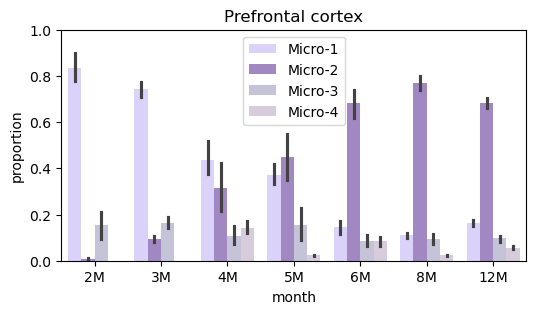

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your cm.palettes.cell_type_colors is already created

# Step 1: Filter the DataFrame
mask = (merged_df["celltype"] == "Micro") & (merged_df["Structure Name"] == "Prefrontal cortex")
cal_df = merged_df[mask].copy()

# Step 2: Calculate proportions in the smallest division
proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())


# Step 3: Rename duplicated MultiIndex levels manually to avoid conflicts
unique_index_names = ['month', 'sample', 'slice', 'month_dup', 'sample_dup', 'slice_dup', 'fine']
proportions.index.names = unique_index_names

# Step 4: Convert the Series to DataFrame without setting a conflicting column name
proportions_df = proportions.reset_index()

# Step 5: Select the relevant columns and rename
proportions_df = proportions_df[['month', 'sample', 'slice', 'fine', 0]]
proportions_df.columns = ['month', 'sample', 'slice', 'fine', 'proportion']


# Step 6: Set the size of the plot
plt.figure(figsize=(6, 3))  # Adjusted to a larger size for better clarity

# Step 7: Plot the barplot
sns.barplot(data=proportions_df, x='month', y="proportion", hue='fine', alpha=0.5, dodge=True, palette=cm.palettes.cell_type_colors, legend="auto")

# Step 8: Customize the legend
plt.legend(loc='best')  # Adjust 'best' as needed

# Step 9: Add a title
plt.title("Prefrontal cortex")

# Step 10: Set the y-axis upper limit to 1
plt.ylim(0, 1)

# Step 11: Display the plot
plt.show()

/tmp/ipykernel_263005/1591692392.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())
/tmp/ipykernel_263005/1591692392.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())


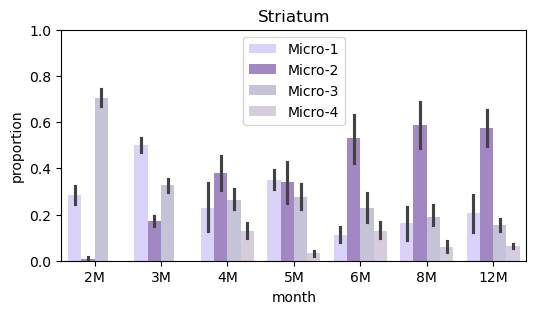

In [38]:
region = "Striatum"

mask = (merged_df["celltype"] == "Micro") & (merged_df["Structure Name"] == region)
cal_df = merged_df[mask].copy()

# Step 2: Calculate proportions in the smallest division
proportions = cal_df.groupby(["month", "sample", "slice", "fine"]).size().groupby(level=[0, 1, 2]).apply(lambda x: x / x.sum())


# Step 3: Rename duplicated MultiIndex levels manually to avoid conflicts
unique_index_names = ['month', 'sample', 'slice', 'month_dup', 'sample_dup', 'slice_dup', 'fine']
proportions.index.names = unique_index_names

# Step 4: Convert the Series to DataFrame without setting a conflicting column name
proportions_df = proportions.reset_index()

# Step 5: Select the relevant columns and rename
proportions_df = proportions_df[['month', 'sample', 'slice', 'fine', 0]]
proportions_df.columns = ['month', 'sample', 'slice', 'fine', 'proportion']


# Step 6: Set the size of the plot
plt.figure(figsize=(6, 3))  # Adjusted to a larger size for better clarity

# Step 7: Plot the barplot
sns.barplot(data=proportions_df, x='month', y="proportion", hue='fine', alpha=0.5, dodge=True, palette=cm.palettes.cell_type_colors, legend="auto")

# Step 8: Customize the legend
plt.legend(loc='best')  # Adjust 'best' as needed

# Step 9: Add a title
plt.title(region)

# Step 10: Set the y-axis upper limit to 1
plt.ylim(0, 1)

# Step 11: Display the plot
plt.show()

In [44]:
brain_region_colors = {
    'BF': '#341FCC',
    'ENT': '#992D6A',
    'HPF': '#D974E8',
    'PFC': '#CC0025',
    'RS': '#FF6F80',
    'STR': '#009909',
    'TH': '#25ADFF',
    "Basal forebrain": "#341FCC",
    "Entorhinal area": "#992D6A",
    "Hippocampal formation": "#D974E8",
    "Prefrontal cortex": "#CC0025",
    "Retrosplenial area": "#FF6F80",
    "Striatum": "#009909",
    "Thalamus": "#25ADFF"
}

In [39]:
fil_df = pd.read_csv("../output/filtered_nei_moranI.csv")

In [46]:
# Define the correct order for months
month_order = ['2M', '3M', '4M', '5M', '6M', '8M', '12M']

# Convert 'month' column to a categorical type with the specified order
fil_df['month'] = pd.Categorical(fil_df['month'], categories=month_order, ordered=True)

/tmp/ipykernel_263005/4135706866.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


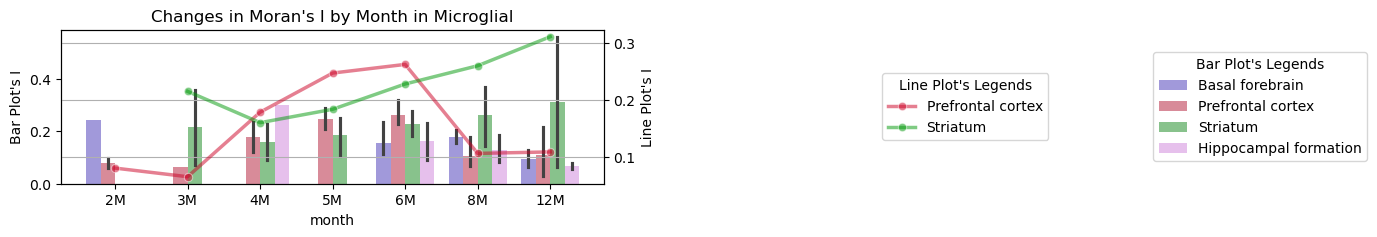

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and the primary y-axis
fig, ax2 = plt.subplots(figsize=(7, 2))

# Create a secondary y-axis for the bar chart
ax1 = ax2.twinx()

# Mask the DataFrame
mask = fil_df["celltype"] == "Micro"
mask &= (fil_df["region"] == "Striatum") | (fil_df["region"] == "Prefrontal cortex") | (fil_df["region"] == "Hippocampal formation") | (fil_df["region"] == "Basal forebrain")

# Plot the bar chart on the secondary y-axis
sns.barplot(ax=ax2, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
            hue='region', dodge=True, palette=brain_region_colors)

# Customize the bar chart
ax2.set_ylabel("Bar Plot's I")
ax2.grid(False)  # Disable the grid on the secondary y-axis

# Adjust mask for line plot
mask = fil_df["celltype"] == "Micro"
mask &= (fil_df["region"] == "Striatum") | (fil_df["region"] == "Prefrontal cortex")

# Plot the line plot on the primary y-axis
sns.lineplot(ax=ax1, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
             hue='region', errorbar=None, marker='o', linewidth=2.5, palette=brain_region_colors)

# Customize the line plot
ax1.set_title('Changes in Moran\'s I by Month in Microglial')
ax1.set_xlabel('Month')
ax1.set_ylabel("Line Plot's I")
ax1.grid(True, axis="y")

# Gather the handles and labels for both plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Hide the original legends
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# Create a combined custom legend outside the figure
legend_line = ax1.legend(handles1, labels1, title="Line Plot's Legends", loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
legend_bar = ax2.legend(handles2, labels2, title="Bar Plot's Legends", loc='center left', bbox_to_anchor=(2, 0.5), ncol=1)

# Adjust the layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("../../refined_plot_0527/long_change_by_time.pdf", dpi = 350)

# Show the plot
plt.show()


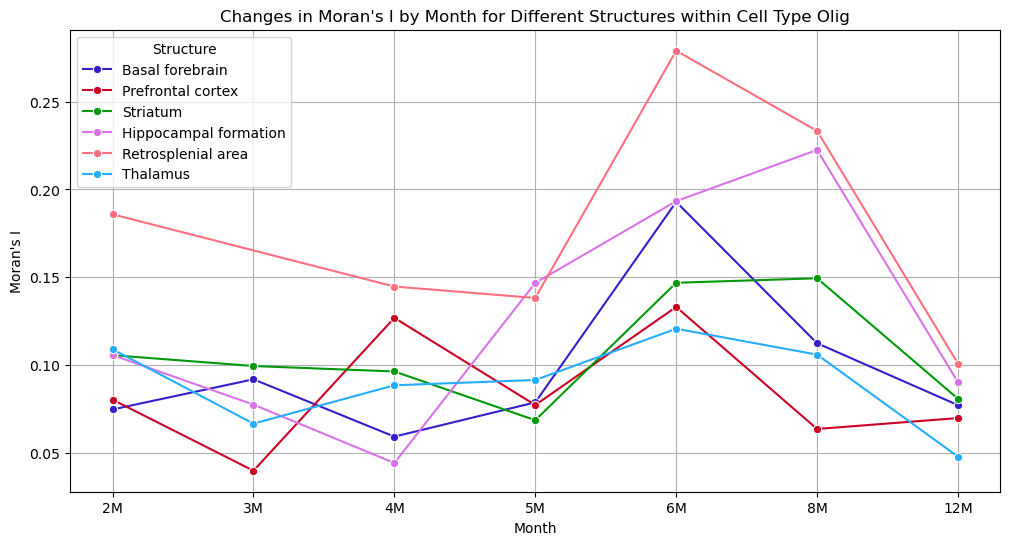

In [138]:
cell_type = "Olig"

plt.figure(figsize=(12, 6))

# Create a mask for the celltype "Micro"
mask = fil_df["celltype"] == cell_type
mask &= fil_df["region"] != "Entorhinal area"

# Apply the mask and use the hue parameter for the "structure" column
sns.lineplot(data=fil_df[mask], x='month', y="Moran's I", hue='region', errorbar=None, marker='o', palette=brain_region_colors)

# Customize the plot (optional)
plt.title(f'Changes in Moran\'s I by Month for Different Structures within Cell Type {cell_type}')
plt.xlabel('Month')
plt.ylabel("Moran's I")
plt.legend(title='Structure')
plt.grid(True)
plt.show()


/tmp/ipykernel_263005/2978139370.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


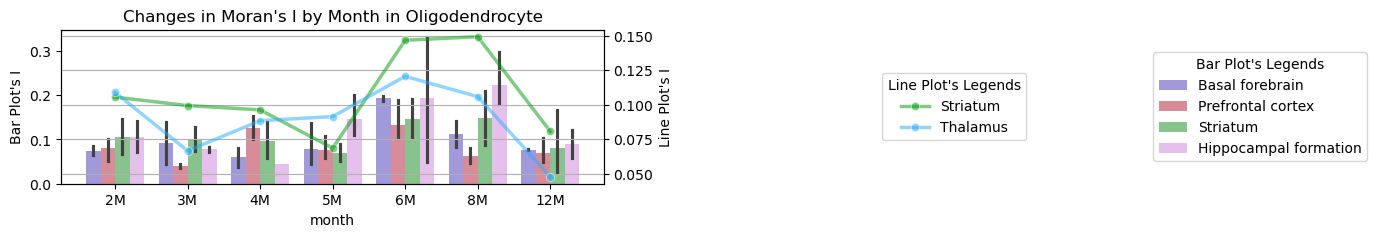

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and the primary y-axis
fig, ax2 = plt.subplots(figsize=(7, 2))

# Create a secondary y-axis for the bar chart
ax1 = ax2.twinx()

# Mask the DataFrame
mask = fil_df["celltype"] == "Olig"
mask &= (fil_df["region"] == "Striatum") | (fil_df["region"] == "Prefrontal cortex") | (fil_df["region"] == "Hippocampal formation") | (fil_df["region"] == "Basal forebrain")

# Plot the bar chart on the secondary y-axis
sns.barplot(ax=ax2, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
            hue='region', dodge=True, palette=brain_region_colors)

# Customize the bar chart
ax2.set_ylabel("Bar Plot's I")
ax2.grid(False)  # Disable the grid on the secondary y-axis

# Adjust mask for line plot
mask = fil_df["celltype"] == "Olig"
mask &= (fil_df["region"] == "Striatum") | (fil_df["region"] == "Thalamus")

# Plot the line plot on the primary y-axis
sns.lineplot(ax=ax1, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
             hue='region', errorbar=None, marker='o', linewidth=2.5, palette=brain_region_colors)

# Customize the line plot
ax1.set_title('Changes in Moran\'s I by Month in Oligodendrocyte')
ax1.set_xlabel('Month')
ax1.set_ylabel("Line Plot's I")
ax1.grid(True, axis="y")

# Gather the handles and labels for both plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Hide the original legends
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# Create a combined custom legend outside the figure
legend_line = ax1.legend(handles1, labels1, title="Line Plot's Legends", loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
legend_bar = ax2.legend(handles2, labels2, title="Bar Plot's Legends", loc='center left', bbox_to_anchor=(2, 0.5), ncol=1)

# Adjust the layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("../../refined_plot_0527/olig_change_by_time.pdf", dpi = 350)

# Show the plot
plt.show()


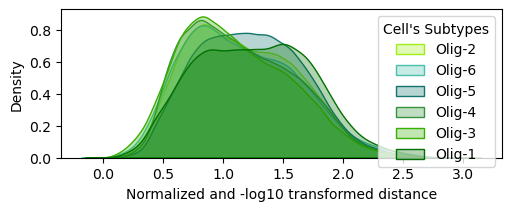

In [131]:
mask = merged_df["celltype"] == "Olig"
micro_df = merged_df[mask].copy()

fig = plt.figure(constrained_layout=True, figsize=(5, 2))
ax = fig.add_subplot(1, 1, 1)
ax = plot_kde_normalized_distance(micro_df, cell_type="Olig",scaling_method="minmax", ax = ax)


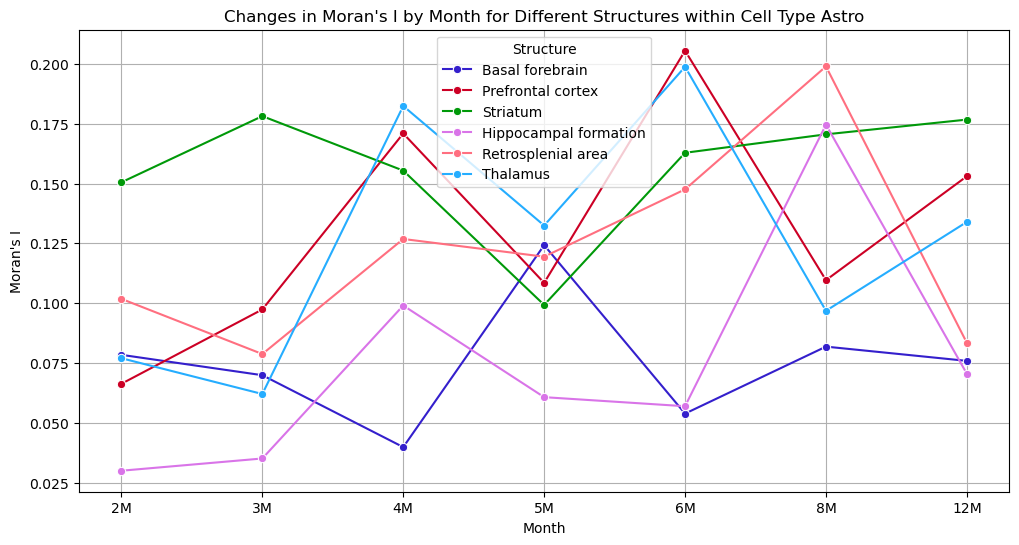

In [153]:
cell_type = "Astro"

plt.figure(figsize=(12, 6))

# Create a mask for the celltype "Micro"
mask = fil_df["celltype"] == cell_type
mask &= fil_df["region"] != "Entorhinal area"

# Apply the mask and use the hue parameter for the "structure" column
sns.lineplot(data=fil_df[mask], x='month', y="Moran's I", hue='region', errorbar=None, marker='o', palette=brain_region_colors)

# Customize the plot (optional)
plt.title(f'Changes in Moran\'s I by Month for Different Structures within Cell Type {cell_type}')
plt.xlabel('Month')
plt.ylabel("Moran's I")
plt.legend(title='Structure')
plt.grid(True)
plt.show()


/tmp/ipykernel_263005/985182100.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


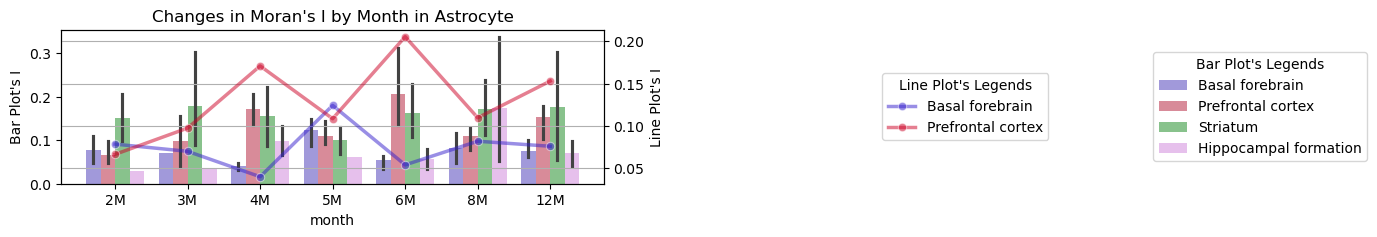

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and the primary y-axis
fig, ax2 = plt.subplots(figsize=(7, 2))

# Create a secondary y-axis for the bar chart
ax1 = ax2.twinx()

# Mask the DataFrame
mask = fil_df["celltype"] == "Astro"
mask &= (fil_df["region"] == "Striatum") | (fil_df["region"] == "Prefrontal cortex") | (fil_df["region"] == "Hippocampal formation") | (fil_df["region"] == "Basal forebrain")

# Plot the bar chart on the secondary y-axis
sns.barplot(ax=ax2, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
            hue='region', dodge=True, palette=brain_region_colors)

# Customize the bar chart
ax2.set_ylabel("Bar Plot's I")
ax2.grid(False)  # Disable the grid on the secondary y-axis

# Adjust mask for line plot
mask = fil_df["celltype"] == "Astro"
mask &= (fil_df["region"] == "Prefrontal cortex") | (fil_df["region"] == "Basal forebrain")

# Plot the line plot on the primary y-axis
sns.lineplot(ax=ax1, data=fil_df[mask], x='month', y="Moran's I", alpha=0.5, 
             hue='region', errorbar=None, marker='o', linewidth=2.5, palette=brain_region_colors)

# Customize the line plot
ax1.set_title('Changes in Moran\'s I by Month in Astrocyte')
ax1.set_xlabel('Month')
ax1.set_ylabel("Line Plot's I")
ax1.grid(True, axis="y")

# Gather the handles and labels for both plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Hide the original legends
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# Create a combined custom legend outside the figure
legend_line = ax1.legend(handles1, labels1, title="Line Plot's Legends", loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
legend_bar = ax2.legend(handles2, labels2, title="Bar Plot's Legends", loc='center left', bbox_to_anchor=(2, 0.5), ncol=1)

# Adjust the layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("../../refined_plot_0527/astro_change_by_time.pdf", dpi = 350)
# Show the plot
plt.show()


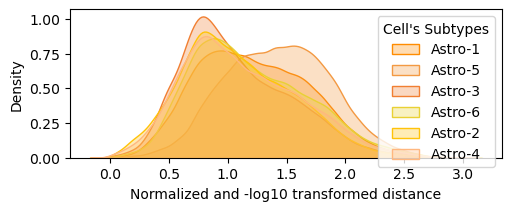

In [132]:
mask = merged_df["celltype"] == "Astro"
micro_df = merged_df[mask].copy()

fig = plt.figure(constrained_layout=True, figsize=(5, 2))
ax = fig.add_subplot(1, 1, 1)
ax = plot_kde_normalized_distance(micro_df, cell_type="Astro",scaling_method="minmax", ax = ax)


# UMAP Plot

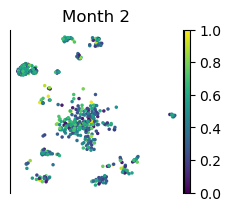

In [104]:
adata = sc.read_h5ad(cellpaths["HZ2M01_Prefrontal cortex"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title(f'Month 2')

plt.savefig("../../refined_plot_0527/month2_umap.pdf", dpi = 350)

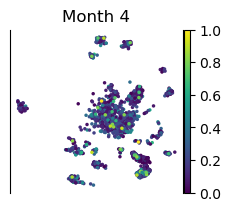

In [142]:
adata = sc.read_h5ad(cellpaths["HZ4M05_Prefrontal cortex"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title(f'Month 4')

plt.savefig("../../refined_plot_0527/month4_umap.pdf", dpi = 350)


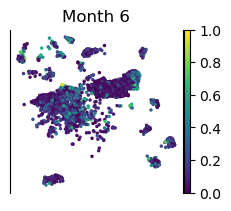

In [106]:
adata = sc.read_h5ad(cellpaths["HZ6MP101_Prefrontal cortex"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 6')

plt.savefig("../../refined_plot_0527/month6_umap.pdf", dpi = 350)

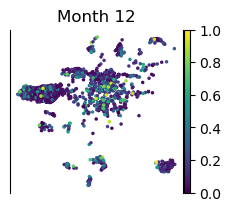

In [107]:
adata = sc.read_h5ad(cellpaths["HZ12M01_Prefrontal cortex"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 12')

plt.savefig("../../refined_plot_0527/month12_umap.pdf", dpi = 350)

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


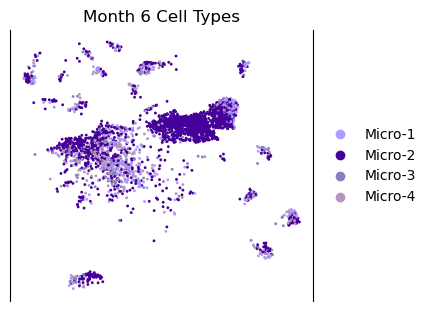

In [123]:
adata = sc.read_h5ad(cellpaths["HZ6MP101_Prefrontal cortex"])

size_pa = 3
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 2.5, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', color = "fine", palette=cm.palettes.cell_type_colors,
                                ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 6 Cell Types')

plt.savefig("../../refined_plot_0527/month12_umap_fine.pdf", dpi = 350)

## Striatum

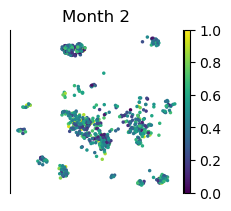

In [140]:
adata = sc.read_h5ad(cellpaths["HZ2M01_Striatum"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title(f'Month 2')

plt.savefig("../../refined_plot_0527/month2_umap_striatum.pdf", dpi = 350)

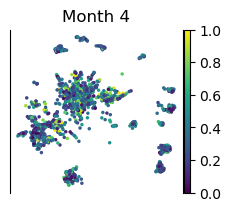

In [143]:
adata = sc.read_h5ad(cellpaths["HZ4M05_Striatum"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title(f'Month 4')

plt.savefig("../../refined_plot_0527/month4_umap_striatum.pdf", dpi = 350)


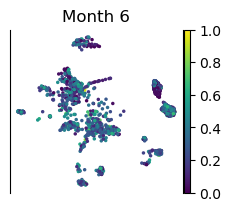

In [144]:
adata = sc.read_h5ad(cellpaths["HZ6MP101_Striatum"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 6')

plt.savefig("../../refined_plot_0527/month6_umap_striatum.pdf", dpi = 350)

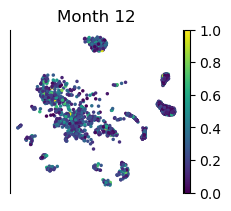

In [145]:
adata = sc.read_h5ad(cellpaths["HZ12M01_Striatum"])

size_pa = 2
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 10, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 12')

plt.savefig("../../refined_plot_0527/month12_umap_striatum.pdf", dpi = 350)

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


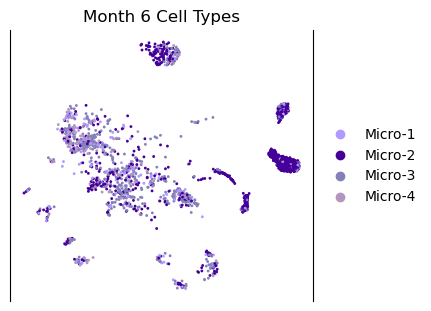

In [146]:
adata = sc.read_h5ad(cellpaths["HZ12M01_Striatum"])

size_pa = 3
fig = plt.figure(constrained_layout=True, figsize=(size_pa + size_pa / 2.5, size_pa))
# Filter for "Micro" cell type
micro_adata = adata[adata.obs["celltype"] == "Micro"]

if micro_adata.n_obs > 0:  # Check if there are any "Micro" cells
    ax = fig.add_subplot(1, 1, 1)
    # Use the custom plotting function to plot directly on the target subplot axis
    plot_normalized_umap_single(micro_adata, cell_type='Micro', color = "fine", palette=cm.palettes.cell_type_colors,
                                ax=ax, sort_order=False, size=50/size_pa)
    ax.set_title('Month 6 Cell Types')

plt.savefig("../../refined_plot_0527/month12_umap_fine_stiratum.pdf", dpi = 350)

# Cell Type Distance Distribution

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

def plot_kde_normalized_distance(
    pfcdf: pd.DataFrame,
    cell_type: str = "Micro",
    dist_col: str = "min_center_dist",
    fine_col: str = "fine",
    palette: dict = cm.palettes.cell_type_colors,
    save_path: str = None,
    fig_size: tuple = (8, 4),
    dpi: int = 350,
    scaling_method: str = "standard",  # Parameter to choose the scaling method
    ax: plt.Axes = None,
    **kde_kwargs
) -> plt.Axes:
    """
    Plots a KDE of normalized and log-transformed distances for a specific cell type in the DataFrame.

    Args:
        pfcdf: DataFrame containing the data.
        cell_type: The cell type to filter on for plotting.
        dist_col: The column name in `pfcdf` to normalize and plot.
        fine_col: The column name representing finer categorization to plot separately.
        palette: Optional dictionary specifying the color palette to use for each `fine` value.
        save_path: Optional path where the plot should be saved. If None, the plot will not be saved.
        fig_size: Size of the figure.
        dpi: Dots per inch for saving the figure.
        scaling_method: Method to use for scaling ('standard', 'minmax', 'maxabs').
        ax: Optional matplotlib axis object to draw on. If None, a new figure and axis will be created.
        **kde_kwargs: Arbitrary keyword arguments to pass to the `sns.kdeplot` function.

    Returns:
        plt.Axes: The matplotlib axis object used for plotting.
    """
    def scale_values(values, method):
        if method == "standard":
            scaler = StandardScaler()
        elif method == "minmax":
            scaler = MinMaxScaler()
        elif method == "maxabs":
            scaler = MaxAbsScaler()
        else:
            raise ValueError("Unsupported scaling method. Choose from 'standard', 'minmax', or 'maxabs'.")
        return scaler.fit_transform(values.reshape(-1, 1)).flatten()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
    else:
        fig = ax.figure
        
    mask = (pfcdf["celltype"] == cell_type) & (pfcdf[dist_col] > 0)
    filtered_data = pfcdf[mask]
    filtered_data = filtered_data.copy()
    filtered_data["fine"] = filtered_data[fine_col].astype(str)

    # Scale the distance values
    filtered_data["dist_scaled"] = scale_values(filtered_data[dist_col].values, scaling_method)
    filtered_data["Normalized and -log10 transformed distance"] = -np.log10(filtered_data["dist_scaled"] + 1e-3)
    plot_color = "Normalized and -log10 transformed distance"

    # Iterate over each unique 'fine' value to plot the KDEs separately
    for fine_value in filtered_data["fine"].unique():
        sns.kdeplot(
            data=filtered_data[filtered_data["fine"] == fine_value],
            x=plot_color,
            label=fine_value,
            ax=ax,
            color=palette[fine_value] if palette else None,
            fill=True,
            alpha=0.3,
            **kde_kwargs
        )

    ax.grid(visible=False)
    ax.legend(title="Cell's Subtypes")  # Add a legend to differentiate KDEs

    # Save the figure only if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    return ax

In [109]:
merged_df.shape

(4116125, 62)

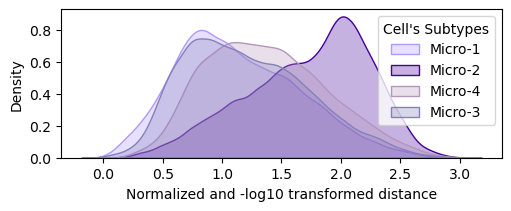

In [127]:
mask = merged_df["celltype"] == "Micro"
micro_df = merged_df[mask].copy()

fig = plt.figure(constrained_layout=True, figsize=(5, 2))
ax = fig.add_subplot(1, 1, 1)
ax = plot_kde_normalized_distance(micro_df, scaling_method="minmax", ax = ax)
plt.savefig("../../refined_plot_0527/micro_distance.pdf", dpi = 350)

# Umap Refine

In [344]:
def hierarchical_sample(
    adata: ad.AnnData,
    groupby_cols: list[str],
    n_samples: int | float | None = None,
    fraction: float | None = None,
    random_state: int | np.random.RandomState | None = None,
) -> ad.AnnData:
    """
    Performs hierarchical random sampling of an AnnData object based on multiple categorical variables.

    Args:
        adata: The AnnData object to sample from.
        groupby_cols: A list of column names from `adata.obs` to use for hierarchical grouping.
        n_samples: The number of samples to select from each group at the final level.
                   If a float, it's interpreted as the fraction of samples to keep.
        fraction: The fraction of samples to keep from each group at the final level.
                  If provided, `n_samples` is ignored.
        random_state: Random seed for reproducibility.

    Returns:
        A new AnnData object containing the sampled cells.
    """
    import anndata as ad
    import pandas as pd
    import numpy as np
    from sklearn.utils import check_random_state
    
    if (n_samples is not None and fraction is not None) or (
        n_samples is None and fraction is None
    ):
        raise ValueError("Must specify exactly one of 'n_samples' or 'fraction'.")

    rng = check_random_state(random_state)

    def _sample_group(group: pd.DataFrame, level: int) -> pd.DataFrame:
        """Recursively samples from each group."""
        if level == len(groupby_cols) - 1:
            # Sample at the final level
            if fraction is not None:
                return group.sample(frac=fraction, random_state=rng)
            elif isinstance(n_samples, int):
                n_to_sample = min(n_samples, len(group))
                return group.sample(n=n_to_sample, random_state=rng)
            elif isinstance(n_samples, float):
                return group.sample(frac=n_samples, random_state=rng)
        else:
            # Group by the next level and sample recursively
            return group.groupby(groupby_cols[level + 1], group_keys=False, observed=False).apply(
                lambda x: _sample_group(x, level + 1)
            )

    # Starting the hierarchical sampling from the top level
    sampled_obs = _sample_group(adata.obs.reset_index(), level=0)
    sampled_obs_index = sampled_obs.index if isinstance(sampled_obs.index, pd.MultiIndex) else sampled_obs.index

    return adata[sampled_obs_index, :].copy()

In [161]:
ref_pfc = sc.read_h5ad("../../annotated_cell_bins/sn_sct_h5ad/PFC_sct_counts.h5ad")

In [165]:
ref_pfc.obs

orig.ident  nCount_RNA  nFeature_RNA genotype month  \
HZ4MSN01_CELL1_N1       HZ4MSN01      3364.0          1981    5xFAD    4M   
HZ4MSN01_CELL4_N1       HZ4MSN01      1781.0          1150    5xFAD    4M   
HZ4MSN01_CELL6_N1       HZ4MSN01      3436.0          1943    5xFAD    4M   
HZ4MSN01_CELL9_N1       HZ4MSN01      3055.0          1790    5xFAD    4M   
HZ4MSN01_CELL10_N1      HZ4MSN01      3660.0          2076    5xFAD    4M   
...                          ...         ...           ...      ...   ...   
WT6MSN29_CELL15337_N1   WT6MSN29      6619.0          3045       WT    6M   
WT6MSN29_CELL15339_N1   WT6MSN29      9263.0          3662       WT    6M   
WT6MSN29_CELL15340_N1   WT6MSN29      3050.0          1666       WT    6M   
WT6MSN29_CELL15341_N1   WT6MSN29      4518.0          2296       WT    6M   
WT6MSN29_CELL15342_N1   WT6MSN29      4694.0          2306       WT    6M   

                       sample slice batch    plaque  plaque_delta  \
HZ4MSN01_CELL1_N1      HZ4M_1   PFC    SN  1.230813      1.137381   
HZ4MSN01_CELL4_N1      HZ4M_1   PFC    SN  1.230813      1.137381   
HZ4MSN01_CELL6_N1      HZ4M_1   PFC    SN  1.230813      1.137381   
HZ4MSN01_CELL9_N1      HZ4M_1   PFC    SN  1.230813      1.137381   
HZ4MSN01_CELL10_N1     HZ4M_1   PFC    SN  1.230813      1.137381   
...                       ...   ...   ...       ...           ...   
WT6MSN29_CELL15337_N1  WT6M_5   PFC    SN       NaN           NaN   
WT6MSN29_CELL15339_N1  WT6M_5   PFC    SN       NaN           NaN   
WT6MSN29_CELL15340_N1  WT6M_5   PFC    SN       NaN           NaN   
WT6MSN29_CELL15341_N1  WT6M_5   PFC    SN       NaN           NaN   
WT6MSN29_CELL15342_N1  WT6M_5   PFC    SN       NaN           NaN   

                       percent.mito  percent.rb  RNA_snn_res.0.2  \
HZ4MSN01_CELL1_N1          1.149425    0.672834               10   
HZ4MSN01_CELL4_N1          0.053648    0.912017                9   
HZ4MSN01_CELL6_N1          0.249931    0.916412                1   
HZ4MSN01_CELL9_N1          1.011339    1.287159                1   
HZ4MSN01_CELL10_N1         0.753442    0.727462                0   
...                             ...         ...              ...   
WT6MSN29_CELL15337_N1      1.419789    0.848946               10   
WT6MSN29_CELL15339_N1      0.583333    0.937500                1   
WT6MSN29_CELL15340_N1      0.730391    1.016196                9   
WT6MSN29_CELL15341_N1      0.679839    1.295942                0   
WT6MSN29_CELL15342_N1      1.148482    1.107465                0   

                       seurat_clusters  celltype         fine  nCount_SCT  \
HZ4MSN01_CELL1_N1                    3         0    ExN-L5-ET      3136.0   
HZ4MSN01_CELL4_N1                    2         0    ExN-L6-CT      2223.0   
HZ4MSN01_CELL6_N1                    1         0  ExN-L2/3-IT      3146.0   
HZ4MSN01_CELL9_N1                    1         0  ExN-L2/3-IT      2985.0   
HZ4MSN01_CELL10_N1                   0         0    ExN-L6-IT      3215.0   
...                                ...       ...          ...         ...   
WT6MSN29_CELL15337_N1                3         0    ExN-L5-ET      3042.0   
WT6MSN29_CELL15339_N1                1         0  ExN-L2/3-IT      2698.0   
WT6MSN29_CELL15340_N1                2         0    ExN-L6-CT      2968.0   
WT6MSN29_CELL15341_N1                0         0    ExN-L6-IT      3260.0   
WT6MSN29_CELL15342_N1                0         0    ExN-L5-IT      3312.0   

                       nFeature_SCT  
HZ4MSN01_CELL1_N1              1981  
HZ4MSN01_CELL4_N1              1152  
HZ4MSN01_CELL6_N1              1942  
HZ4MSN01_CELL9_N1              1790  
HZ4MSN01_CELL10_N1             2076  
...                             ...  
WT6MSN29_CELL15337_N1          2038  
WT6MSN29_CELL15339_N1          1720  
WT6MSN29_CELL15340_N1          1666  
WT6MSN29_CELL15341_N1          2261  
WT6MSN29_CELL15342_N1          2250  

[355881 rows x 18 columns]

In [356]:
ref_pfc_sub = cm.hierarchical_sample(ref_pfc, groupby_cols=["sample", "celltype"], n_samples=10000, random_state=1)

In [357]:
ref_pfc_sub.obs["celltype"] = ref_pfc_sub.obs["fine"].str.split("-").str[0]

In [358]:

test = ref_pfc_sub.obs.groupby("celltype").count()
test["fine"]

celltype
Astro     1017
Endo      1388
ExN      10000
InN      10000
Micro     1315
OPC       1290
Olig      1857
Peri      2004
SMC        524
Name: fine, dtype: int64

In [360]:
ref_pfc_sub.raw.var.set_index("_index", inplace=True)

In [361]:
ref_pfc_sub = ref_pfc_sub.raw.to_adata()

In [362]:
# Reusing the previously defined functions:
cellbin_dir = "/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad"
meta_dir = "/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/region_meta/"

In [363]:
metas = cm.io.read_and_process_metadata(meta_dir, criteria="'4M' in file")

/public/home/jijh/st_project/cellbin_analysis/cellbin_moranI/cellbin_moran/io/file_operations.py:75: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  directory: The directory to search for metadata files.
/public/home/jijh/st_project/cellbin_analysis/cellbin_moranI/cellbin_moran/io/file_operations.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  
/public/home/jijh/st_project/cellbin_analysis/cellbin_moranI/cellbin_moran/io/file_operations.py:75: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  directory: The directory to search for metadata files.
/public/home/jijh/st_project/cellbin_analysis/cellbin_moranI/cellbin_moran/io/file_operations.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  
/public/home/jijh/st_project/cellbin_analysis/cellbin_moranI/cellbin_moran/io/file_operations.py:75: DtypeWarn

In [364]:
sample_5m = cm.list_files_matching_criteria(cellbin_dir, condition="'4M' in file")

In [365]:
sample_5m

{'HZ4M03': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4M03_sct_counts.h5ad',
 'HZ4M05': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4M05_sct_counts.h5ad',
 'HZ4MP101': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4MP101_sct_counts.h5ad',
 'HZ4MP102': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4MP102_sct_counts.h5ad',
 'HZ4MP202': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4MP202_sct_counts.h5ad'}

In [366]:
adata_sample = cm.load_sct_and_set_index(sample_5m["HZ4M05"])

In [367]:
adata_sample = adata_sample.raw.to_adata()

In [368]:
adata_sample.obs = metas["HZ4M05"]

In [369]:
adata_sample.obs["Structure Name"].unique()

array(['NA', 'Prefrontal cortex', 'Striatum', 'Basal forebrain',
       'Hippocampal formation'], dtype=object)

In [370]:
adata_pdf = cm.subset_anndata(adata_sample, {"Structure Name": "Prefrontal cortex"})

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [371]:
adata_pdf.obs["datatype"] = "cellbin"
ref_pfc_sub.obs["datatype"] = "sn"

In [372]:
import anndata as ad

In [373]:
merge_adata = cm.analysis.spatial_analysis.concatenate_and_intersect([adata_pdf, ref_pfc_sub])

In [374]:
merge_adata.obs["nCount_SCT"]

11                        299.0
27                        639.0
28                        452.0
36                        722.0
38                        423.0
                          ...  
HZ5MSN01_CELL6858_N1     2183.0
WT2MSN08_CELL2810_N3     2820.0
HZ6MSN01_CELL12324_N1    2195.0
HZ2MSN15_CELL6043_N2     2637.0
WT6MSN15_CELL2718_N2     3504.0
Name: nCount_SCT, Length: 77091, dtype: float64

## nor_log_pca

In [375]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [376]:
merge_adata.layers["counts"] = merge_adata.X

In [377]:
sc.pp.normalize_total(merge_adata, target_sum=1e4)
sc.pp.log1p(merge_adata)

normalizing counts per cell
    finished (0:00:01)


In [378]:
sc.pp.highly_variable_genes(merge_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


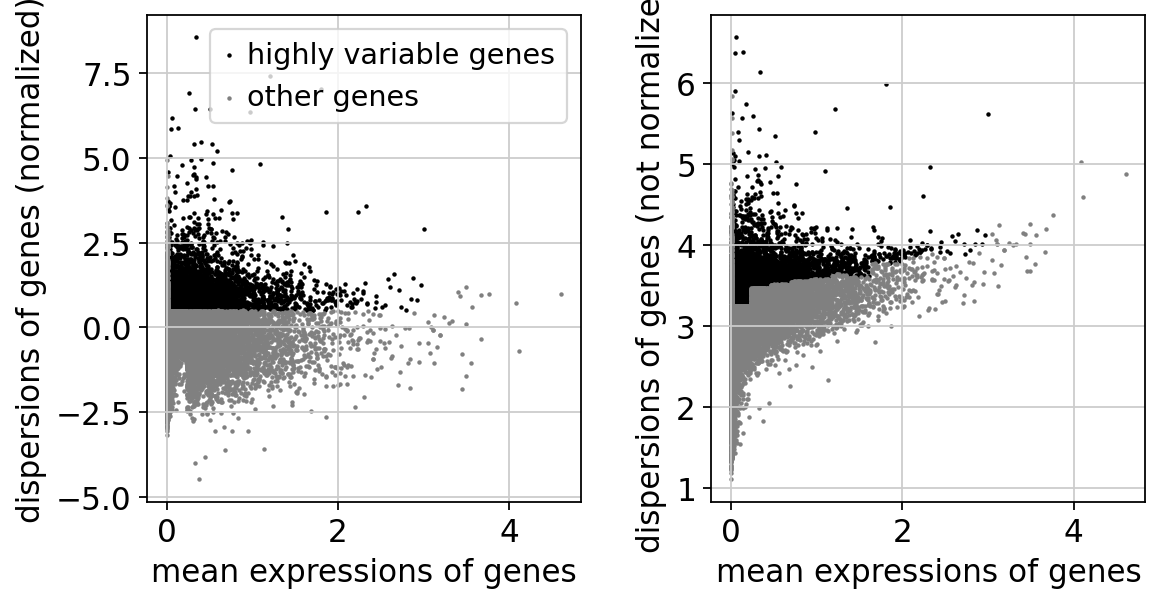

In [379]:
sc.pl.highly_variable_genes(merge_adata)

In [380]:
merge_adata.raw = merge_adata

In [381]:
merge_adata = merge_adata[:, merge_adata.var.highly_variable]

In [382]:
merge_adata.obs["datatype"].unique()

array(['cellbin', 'sn'], dtype=object)

<Axes: xlabel='nCount_SCT', ylabel='Density'>

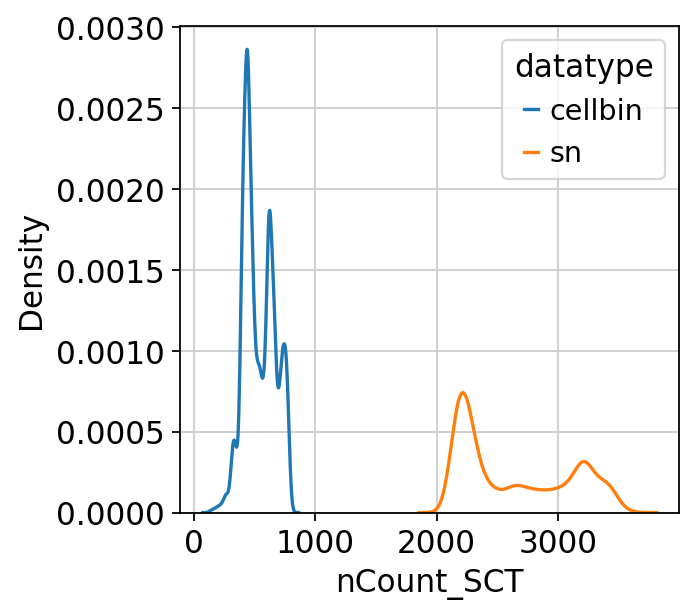

In [383]:
sns.kdeplot(data = merge_adata.obs, x = "nCount_SCT", hue = "datatype")

In [384]:
sc.pp.regress_out(merge_adata, ["nCount_SCT"])

regressing out ['nCount_SCT']


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying

    sparse input is densified and may lead to high memory use
    finished (0:28:43)


In [385]:
sc.pp.scale(merge_adata, max_value=10)

In [386]:
sc.tl.pca(merge_adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:01:31)


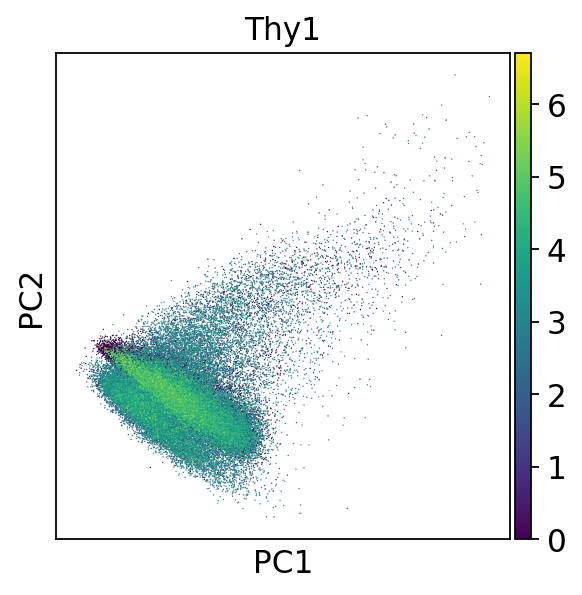

In [387]:
sc.pl.pca(merge_adata, color="Thy1")

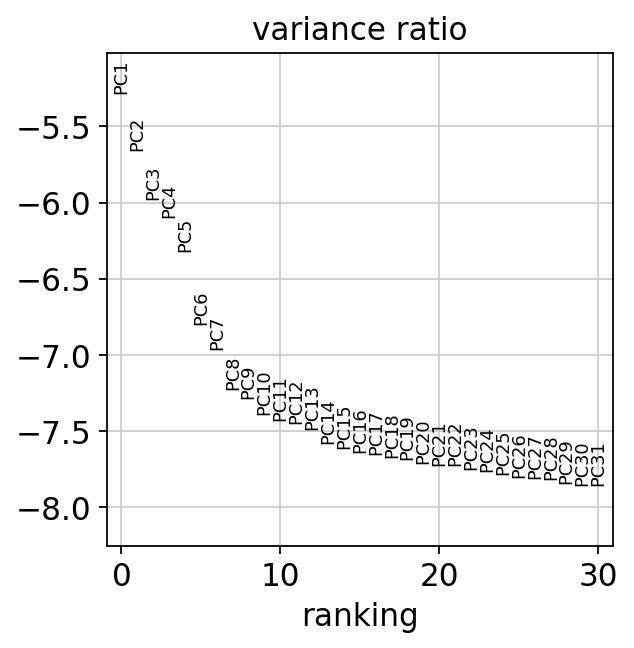

In [388]:
sc.pl.pca_variance_ratio(merge_adata, log=True)

## UMAP

In [ ]:
sc.pp.neighbors(merge_adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [ ]:
sc.tl.umap(merge_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:04)


In [ ]:
merge_adata.obs["fine"].str.split("-").str[0]

11                       Micro
27                        Endo
28                        Peri
36                         SMC
38                         SMC
                         ...  
HZ5MSN01_CELL6858_N1       SMC
WT2MSN08_CELL2810_N3       SMC
HZ6MSN01_CELL12324_N1      SMC
HZ2MSN15_CELL6043_N2       SMC
WT6MSN15_CELL2718_N2       SMC
Name: fine, Length: 77091, dtype: object

In [ ]:
merge_adata.obs["celltype"] = merge_adata.obs["fine"].str.split("-").str[0]

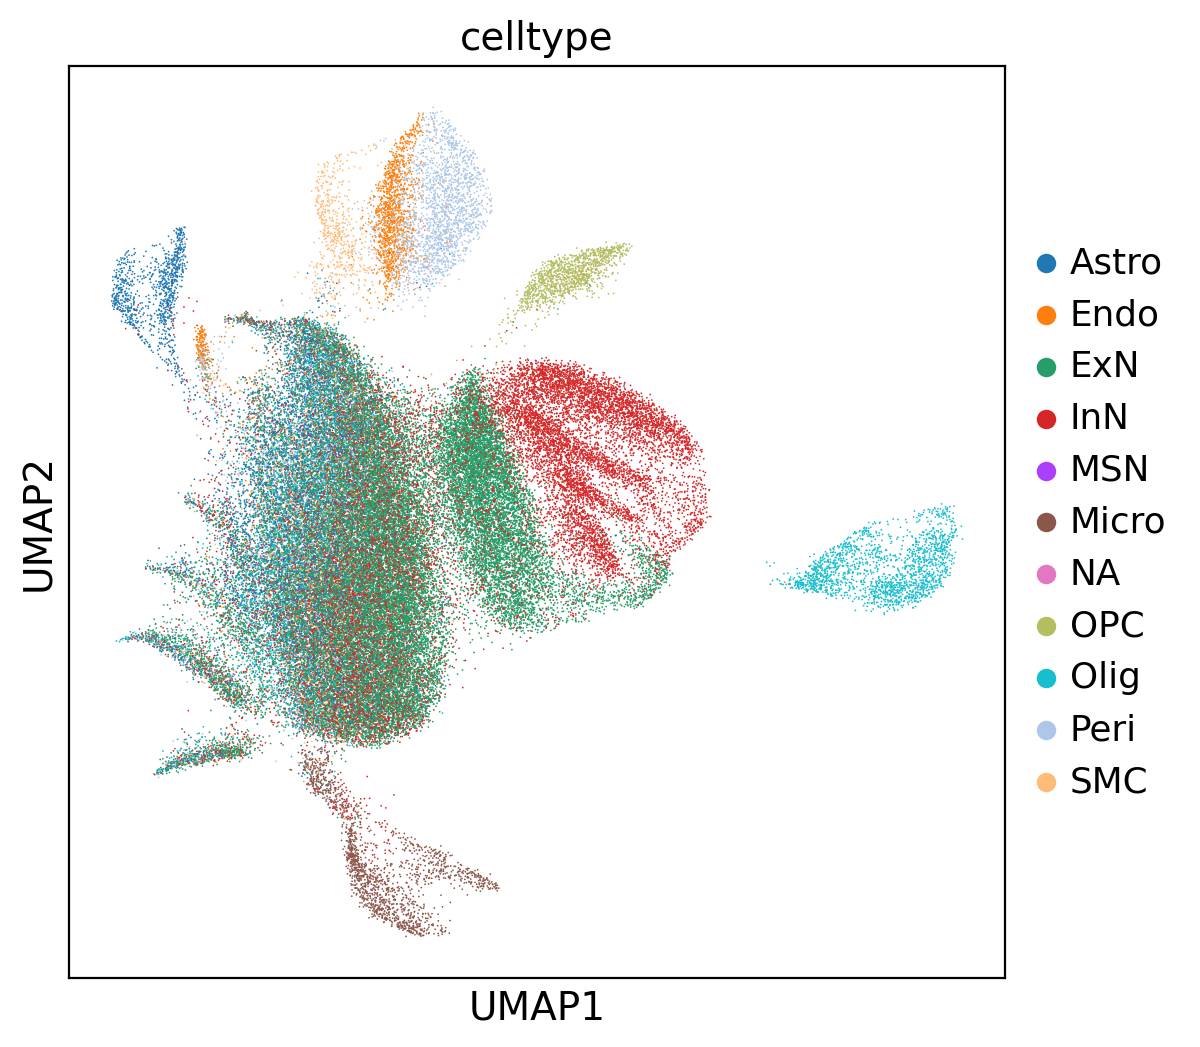

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
sc.pl.umap(merge_adata, color = "celltype", ax = ax)


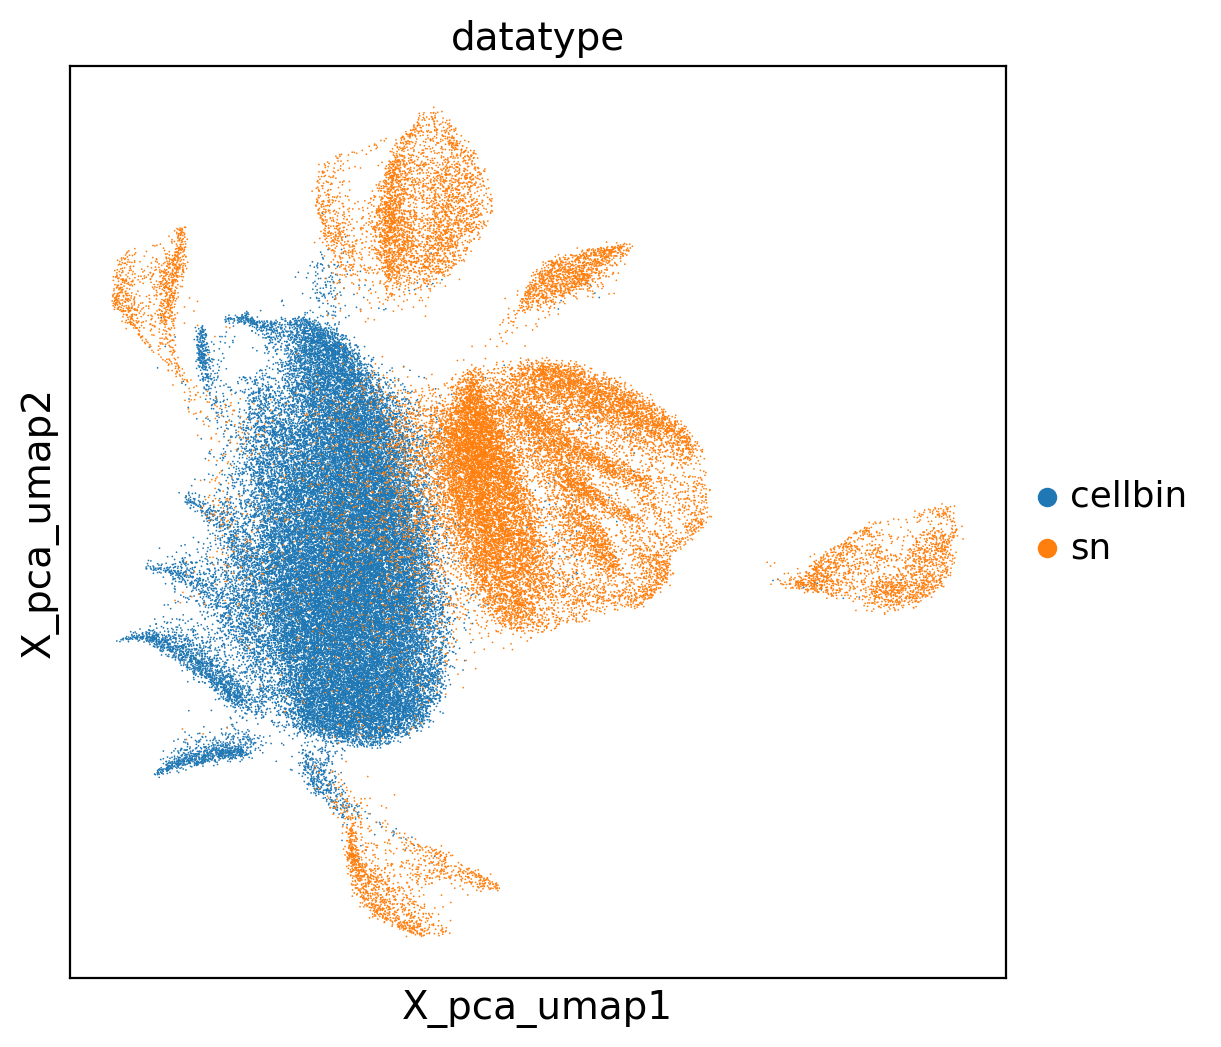

In [427]:

fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
sc.pl.embedding(merge_adata, basis = "X_pca_umap", color = "datatype", ax = ax)


In [ ]:
merge_adata.obsm["X_pca_umap"] = merge_adata.obsm["X_umap"]

## 还是得harmony

In [ ]:
merge_adata

AnnData object with n_obs × n_vars = 77091 × 4458
    obs: 'Unnamed: 0', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'fine', 'genotype', 'month', 'sample', 'slice', 'id_A', 'age', 'nearest_plaque', 'interval', 'min_center_dist', 'min_border_dist', 'plaque_region', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'nearest_index', 'struct_id', 'acronym_x', 'id_B', 'atlas_id', 'name', 'acronym_y', 'st_level', 'ontology_id', 'hemisphere_id', 'weight', 'parent_structure_id', 'depth', 'graph_id', 'graph_order', 'structure_id_path', 'color_hex_triplet', 'neuro_name_structure_id', 'neuro_name_structure_id_path', 'failed', 'sphinx_id', 'structure_name_facet', 'failed_facet', 'safe_name', 'total_voxel_counts (10 um)', 'Structure independently delineated (not merged to form parents)', 'Major Division', '"Summary Structure" Level for Analyses', 'Structure Name', 'datatype', 'nCount_RNA', 'nFeature_RNA', 'batch', 'plaque', 'plaque_delta', 'percent.mito', 'percent.rb', 'RN

In [ ]:
sc.external.pp.harmony_integrate(merge_adata, key="datatype")


2024-06-04 01:46:04,043 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-04 01:46:46,702 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-04 01:46:47,474 - harmonypy - INFO - Iteration 1 of 10
2024-06-04 01:47:29,268 - harmonypy - INFO - Iteration 2 of 10
2024-06-04 01:48:07,985 - harmonypy - INFO - Iteration 3 of 10
2024-06-04 01:48:46,966 - harmonypy - INFO - Iteration 4 of 10
2024-06-04 01:49:26,594 - harmonypy - INFO - Iteration 5 of 10
2024-06-04 01:50:00,376 - harmonypy - INFO - Iteration 6 of 10
2024-06-04 01:50:23,143 - harmonypy - INFO - Converged after 6 iterations


In [ ]:
sc.pp.neighbors(merge_adata, n_neighbors=10, n_pcs=40, use_rep="X_pca_harmony")
sc.tl.umap(merge_adata)
merge_adata.obsm["X_harmony_umap"] = merge_adata.obsm["X_umap"]

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:11)


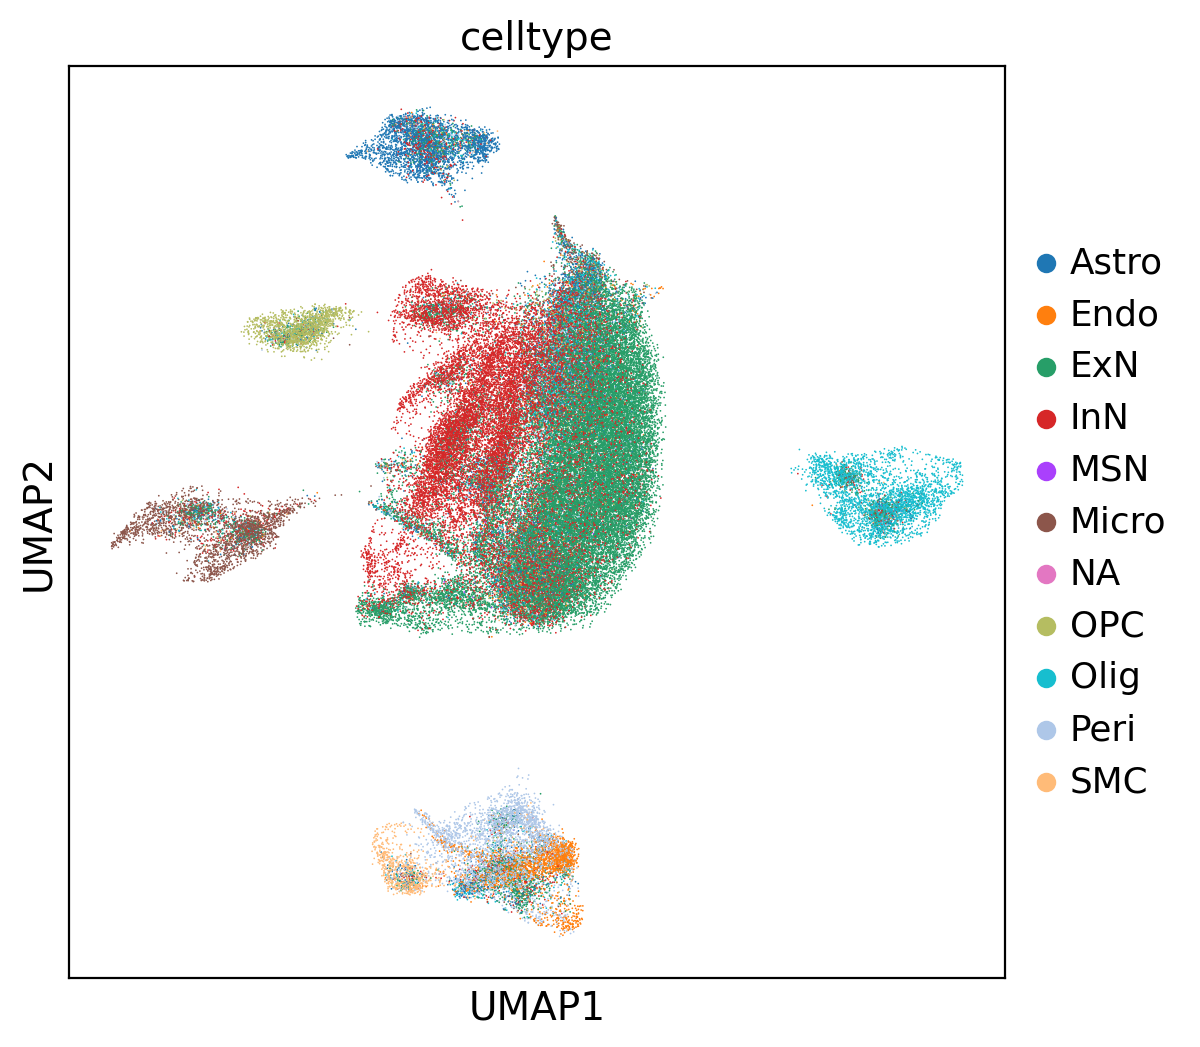

In [402]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
sc.pl.umap(merge_adata, color = "celltype", ax = ax)


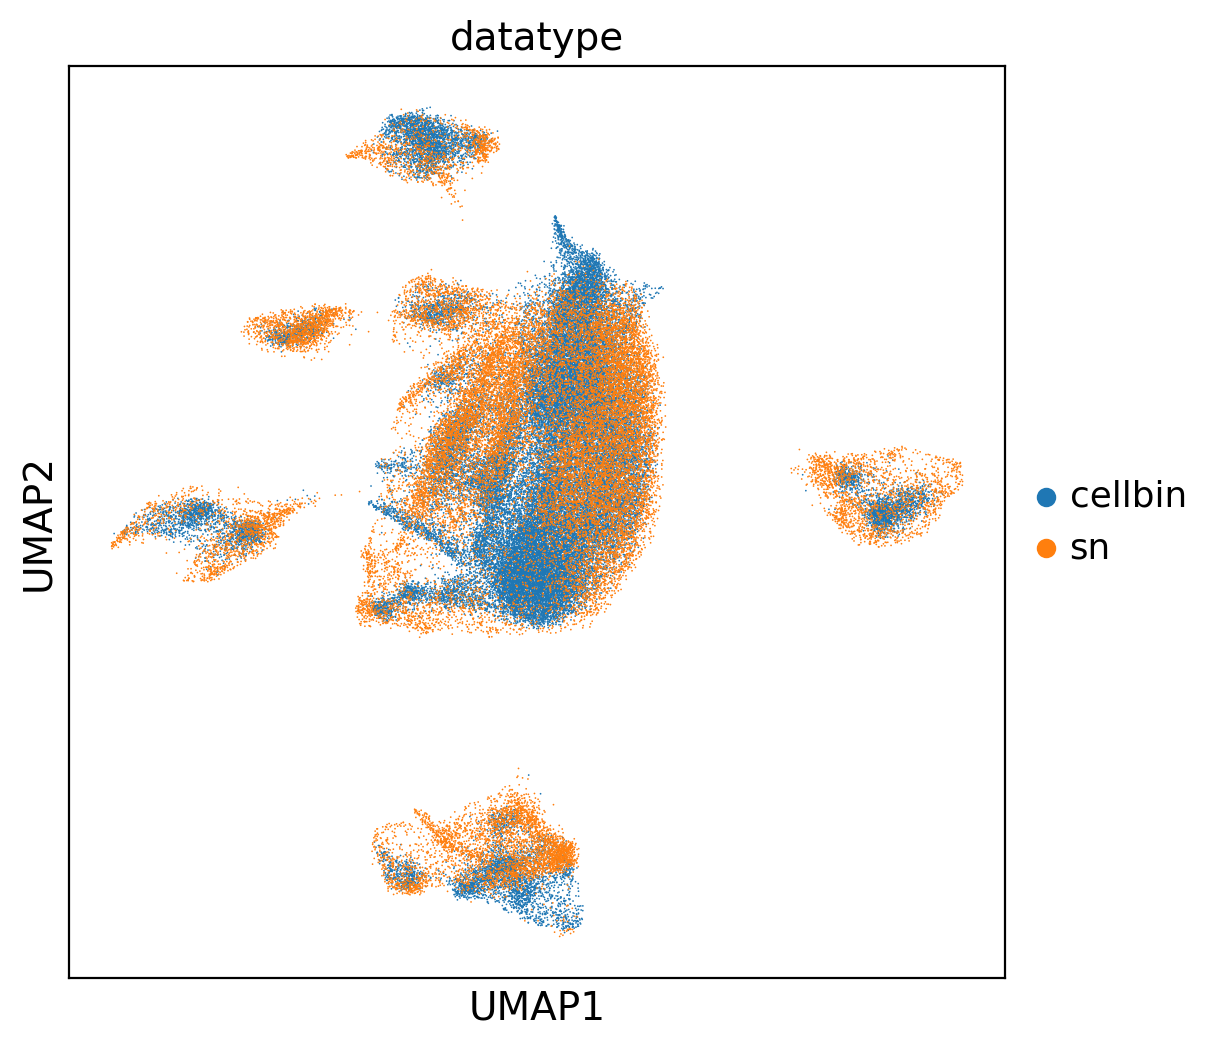

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
sc.pl.umap(merge_adata, color = "datatype", ax = ax)


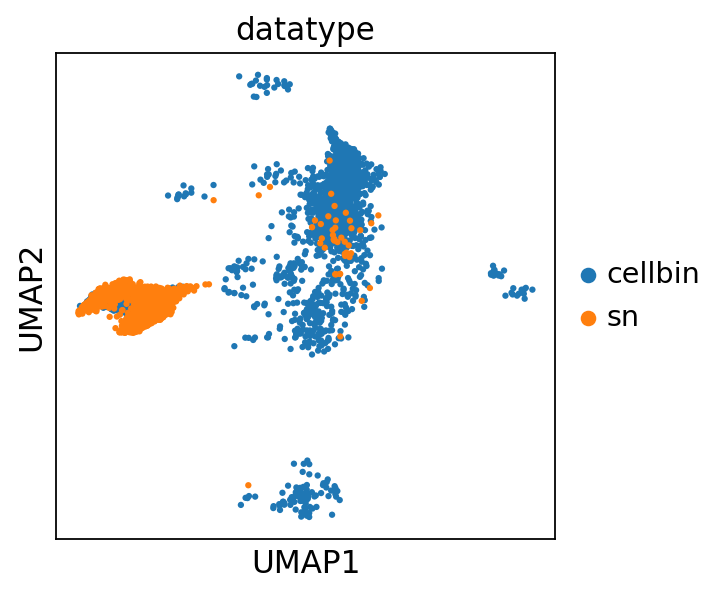

In [ ]:
mask = merge_adata.obs["celltype"] == 'Micro'
sc.pl.umap(merge_adata[mask], color = "datatype")

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


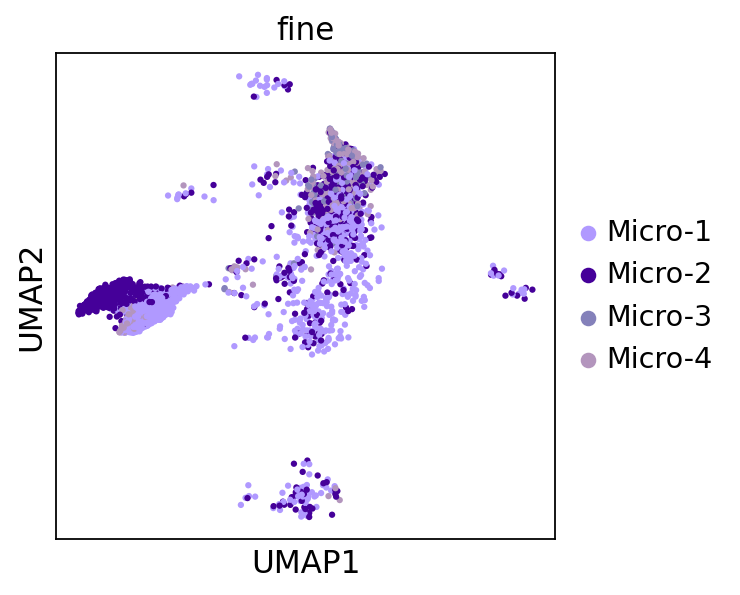

In [406]:
mask = merge_adata.obs["celltype"] == 'Micro'
sc.pl.umap(merge_adata[mask], color = "fine", palette=cm.palettes.cell_type_colors)

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


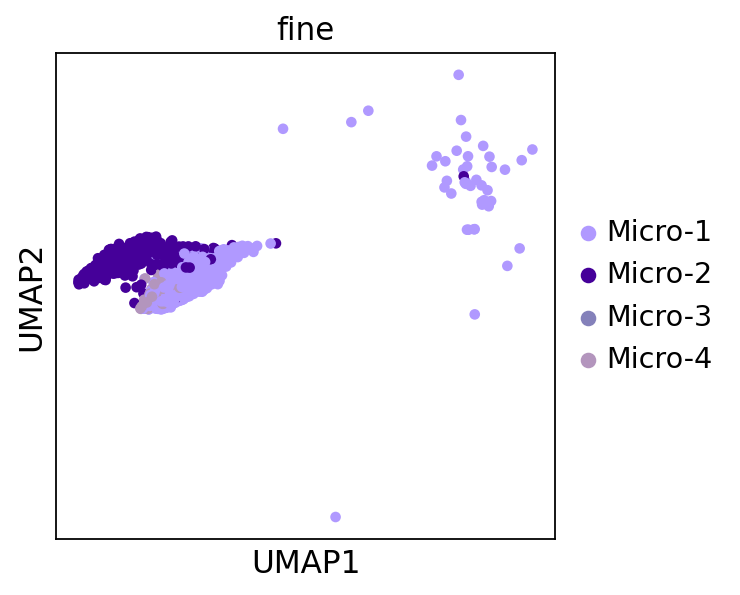

In [407]:
mask = (merge_adata.obs["celltype"] == 'Micro') & (merge_adata.obs["datatype"] == 'sn')
sc.pl.umap(merge_adata[mask], color = "fine", palette=cm.palettes.cell_type_colors)

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


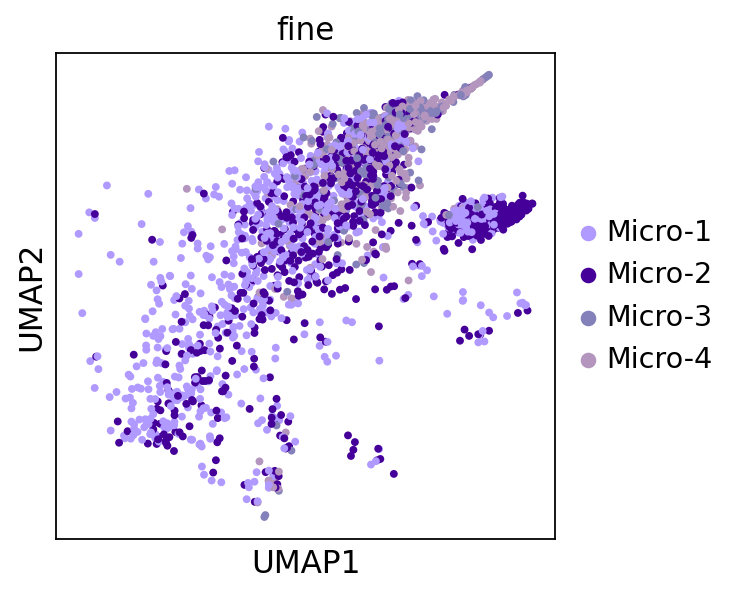

In [307]:
mask = (merge_adata.obs["celltype"] == 'Micro') & (merge_adata.obs["datatype"] == 'cellbin')
sc.pl.umap(merge_adata[mask], color = "fine", palette=cm.palettes.cell_type_colors)

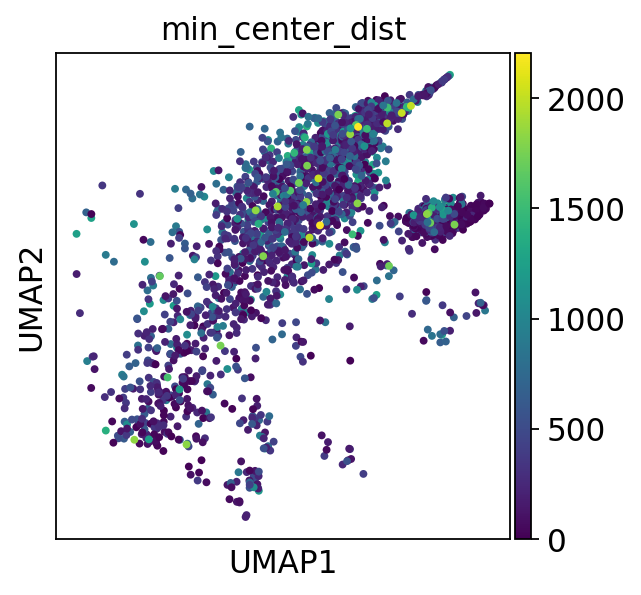

In [311]:
mask = (merge_adata.obs["celltype"] == 'Micro') & (merge_adata.obs["datatype"] == 'cellbin')
sc.pl.umap(merge_adata[mask], color = "min_center_dist", sort_order=False)

In [316]:
mask = merge_adata.obs["datatype"] == 'cellbin'
df = cm.analysis.compute_moranI(merge_adata[mask], genes=["min_center_dist"])

Micro: 2403
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
Endo: 909
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
Peri: 2089
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)
SMC: 1028
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)
Astro: 5664
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)
Olig: 3877
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)
ExN: 23274
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:05)
InN: 7838
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
OPC: 591
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)
MSN: 22
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:02)


In [317]:
df_nei = cm.analysis.spatial_analysis.

I     pval_norm  var_norm    pval_z_sim  pval_sim   var_sim  \
celltype                                                                       
SMC       0.272686  0.000000e+00  0.000285  0.000000e+00  0.009901  0.000395   
Micro     0.111881  0.000000e+00  0.000124  0.000000e+00  0.009901  0.000097   
Endo      0.090816  1.352196e-07  0.000319  5.639329e-09  0.009901  0.000247   
Peri      0.080799  4.482081e-12  0.000142  0.000000e+00  0.009901  0.000088   
Olig      0.080697  0.000000e+00  0.000077  0.000000e+00  0.009901  0.000060   
MSN       0.065950  1.085453e-01  0.008466  1.623967e-01  0.207921  0.005150   
Astro     0.056087  5.107026e-15  0.000053  0.000000e+00  0.009901  0.000035   
ExN       0.053218  0.000000e+00  0.000013  0.000000e+00  0.009901  0.000007   
InN       0.052979  0.000000e+00  0.000038  0.000000e+00  0.009901  0.000021   
OPC       0.015769  2.160415e-01  0.000494  1.732483e-01  0.178218  0.000238   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  num_cell  
celltype                                                                  
SMC           0.000000e+00       0.000000e+00         0.009901      1028  
Micro         0.000000e+00       0.000000e+00         0.009901      2403  
Endo          1.352196e-07       5.639329e-09         0.009901       909  
Peri          4.482081e-12       0.000000e+00         0.009901      2089  
Olig          0.000000e+00       0.000000e+00         0.009901      3877  
MSN           1.085453e-01       1.623967e-01         0.207921        22  
Astro         5.107026e-15       0.000000e+00         0.009901      5664  
ExN           0.000000e+00       0.000000e+00         0.009901     23274  
InN           0.000000e+00       0.000000e+00         0.009901      7838  
OPC           2.160415e-01       1.732483e-01         0.178218       591

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


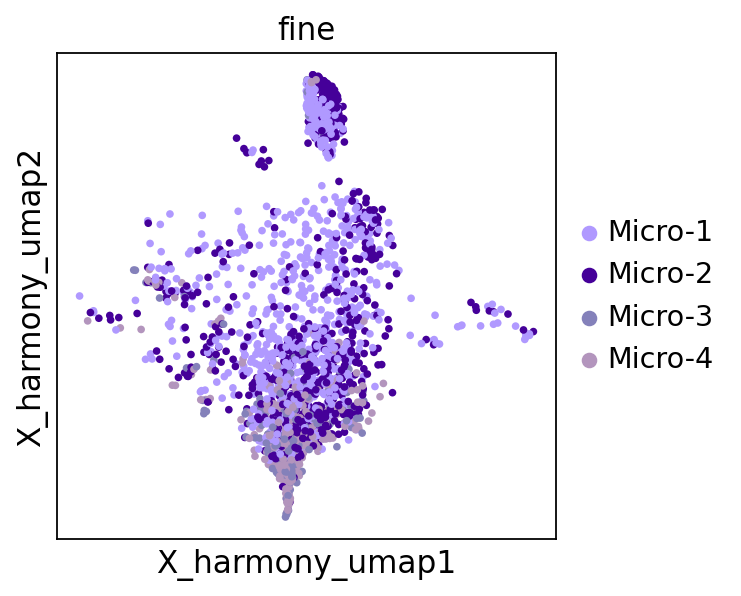

In [306]:
mask = merge_adata.obs["celltype"] == 'Micro'
sc.pl.embedding(merge_adata[mask], basis = "X_harmony_umap", color = "fine", palette=cm.palettes.cell_type_colors)

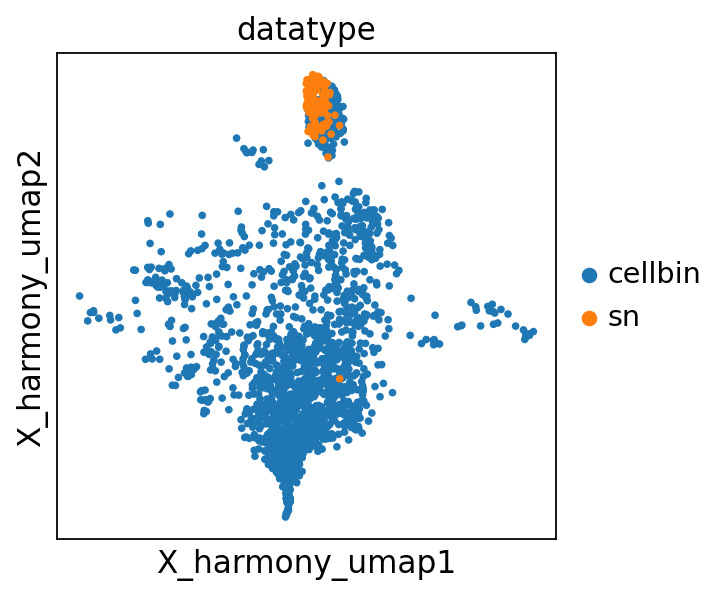

In [309]:
mask = merge_adata.obs["celltype"] == 'Micro'
sc.pl.embedding(merge_adata[mask], basis = "X_harmony_umap", color = "datatype")

In [339]:
ref_pfc_sub.obs.groupby("celltype").count()

orig.ident  nCount_RNA  nFeature_RNA  genotype  month  sample  \
celltype                                                                  
Astro             89          89            89        89     89      89   
Endo             138         138           138       138    138     138   
ExN            29695       29695         29695     29695  29695   29695   
InN             4965        4965          4965      4965   4965    4965   
Micro            127         127           127       127    127     127   
OPC              129         129           129       129    129     129   
Olig             181         181           181       181    181     181   
Peri             211         211           211       211    211     211   
SMC               53          53            53        53     53      53   

          slice  batch  plaque  plaque_delta  percent.mito  percent.rb  \
celltype                                                                 
Astro        89     89      48            48            89          89   
Endo        138    138      82            82           138         138   
ExN       29695  29695   17149         17149         29695       29695   
InN        4965   4965    2776          2776          4965        4965   
Micro       127    127      67            67           127         127   
OPC         129    129      67            67           129         129   
Olig        181    181     142           142           181         181   
Peri        211    211     101           101           211         211   
SMC          53     53      26            26            53          53   

          RNA_snn_res.0.2  seurat_clusters   fine  nCount_SCT  nFeature_SCT  \
celltype                                                                      
Astro                  89               89     89          89            89   
Endo                  138              138    138         138           138   
ExN                 29695            29695  29695       29695         29695   
InN                  4965             4965   4965        4965          4965   
Micro                 127              127    127         127           127   
OPC                   129              129    129         129           129   
Olig                  181              181    181         181           181   
Peri                  211              211    211         211           211   
SMC                    53               53     53          53            53   

          datatype  
celltype            
Astro           89  
Endo           138  
ExN          29695  
InN           4965  
Micro          127  
OPC            129  
Olig           181  
Peri           211  
SMC             53

In [434]:
df = merge_adata.obs
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).replace('nan', 'NA')
merge_adata.obs = df

In [435]:
merge_adata.write("../../annotated_cell_bins/regress_harmony/HZ4M05_PFC_regress_harmony.h5ad")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)
--> added 'pos', the PAGA positions (adata.uns['paga'])


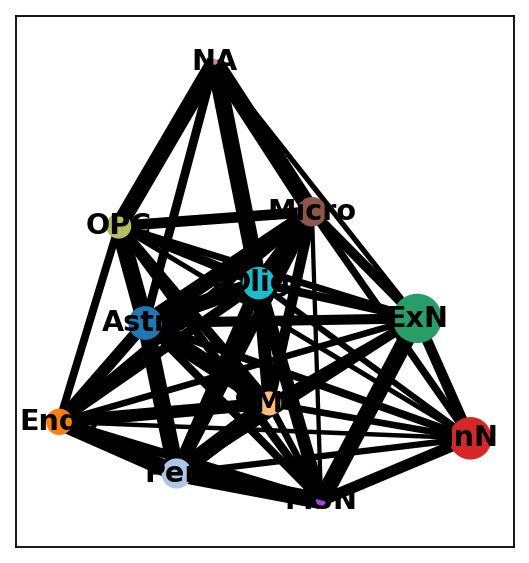

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:38)


In [408]:
sc.tl.paga(merge_adata, groups="celltype")
sc.pl.paga(merge_adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(merge_adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:04)
--> added 'pos', the PAGA positions (adata.uns['paga'])


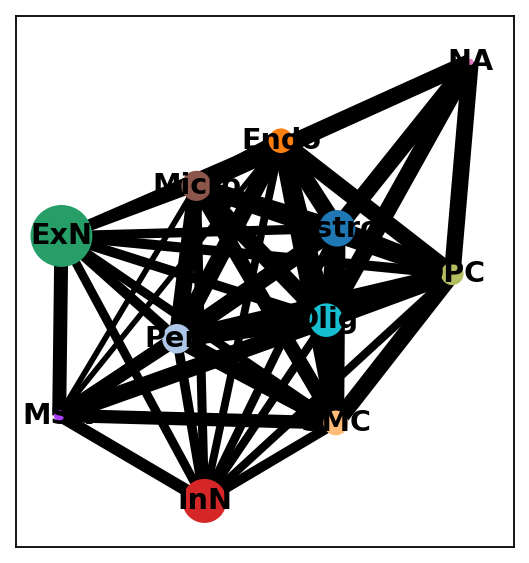

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:56)


In [299]:
sc.tl.paga(merge_adata, groups="celltype")
sc.pl.paga(merge_adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(merge_adata, init_pos='paga')

--> added 'pos', the PAGA positions (adata.uns['paga'])


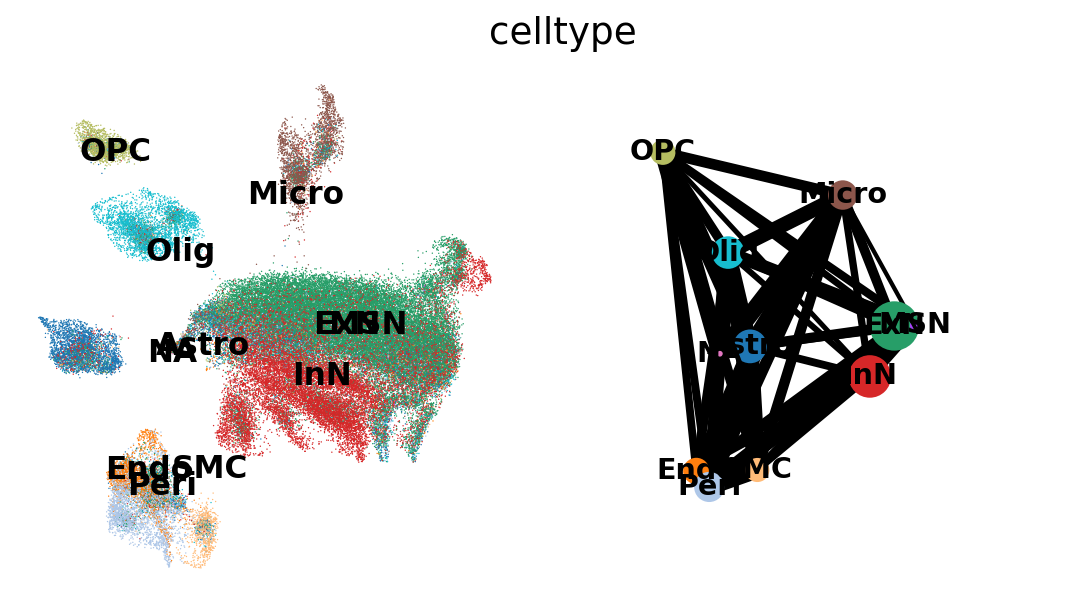

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [409]:
sc.pl.paga_compare(merge_adata, threshold=0.03)

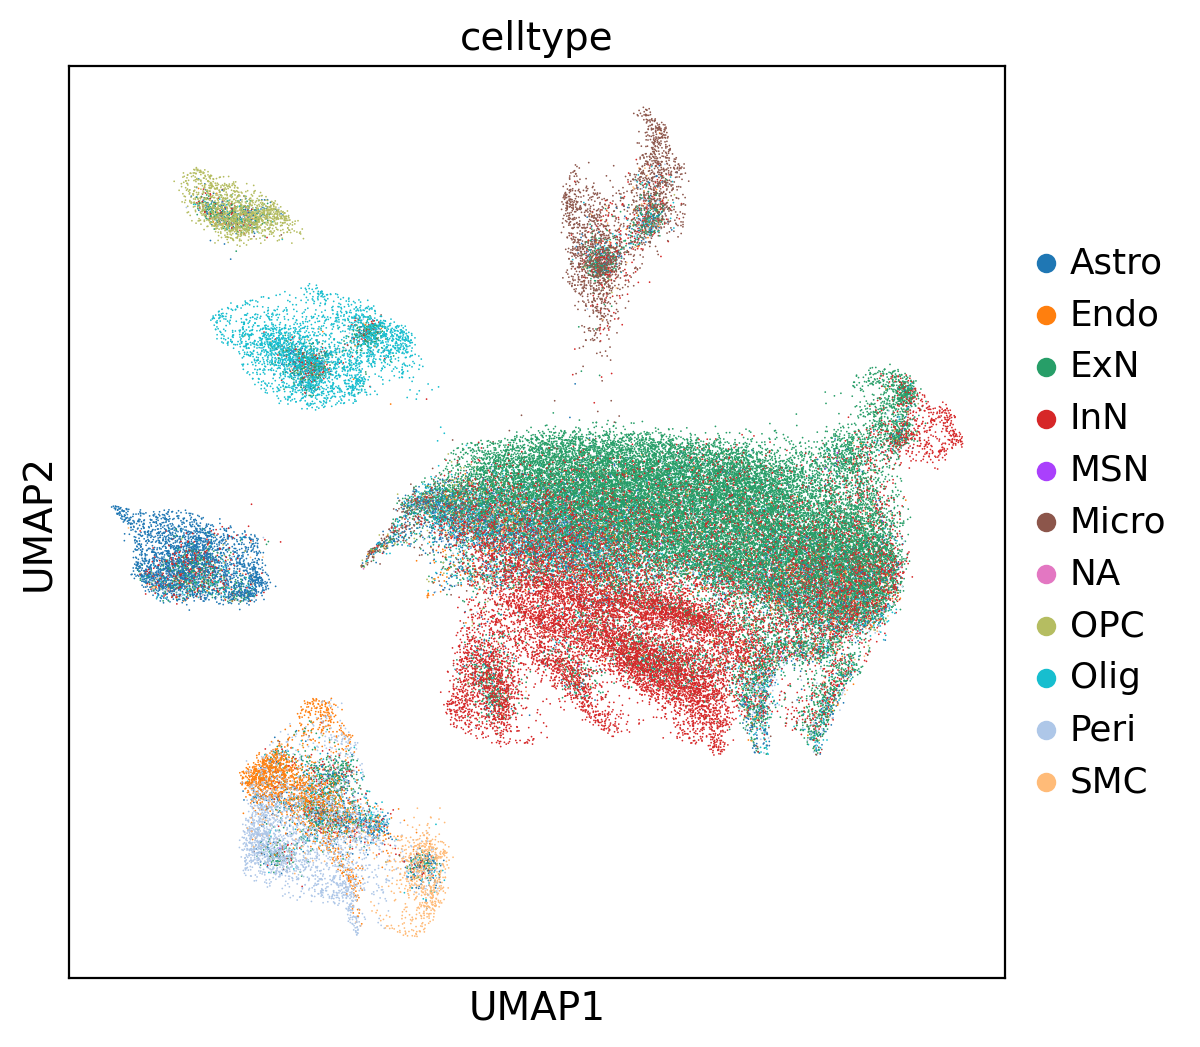

In [411]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
sc.pl.umap(merge_adata, color = "celltype", ax = ax)


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


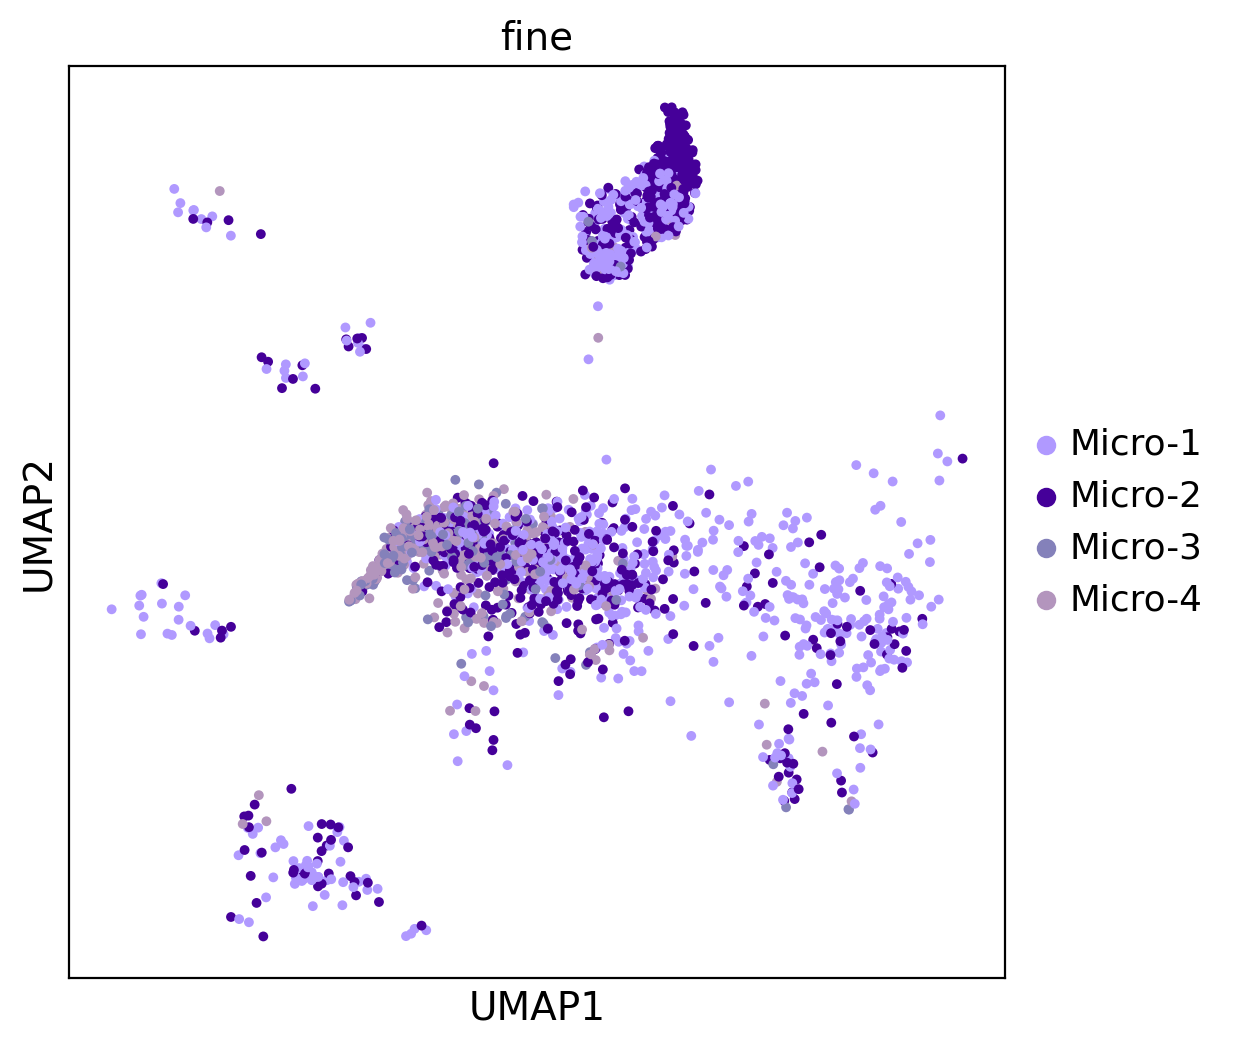

In [417]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
mask = (merge_adata.obs["datatype"] == "cellbin") & (merge_adata.obs["celltype"] == "Micro")
sc.pl.umap(merge_adata[mask], color = "fine", ax = ax, palette=cm.palettes.cell_type_colors)


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


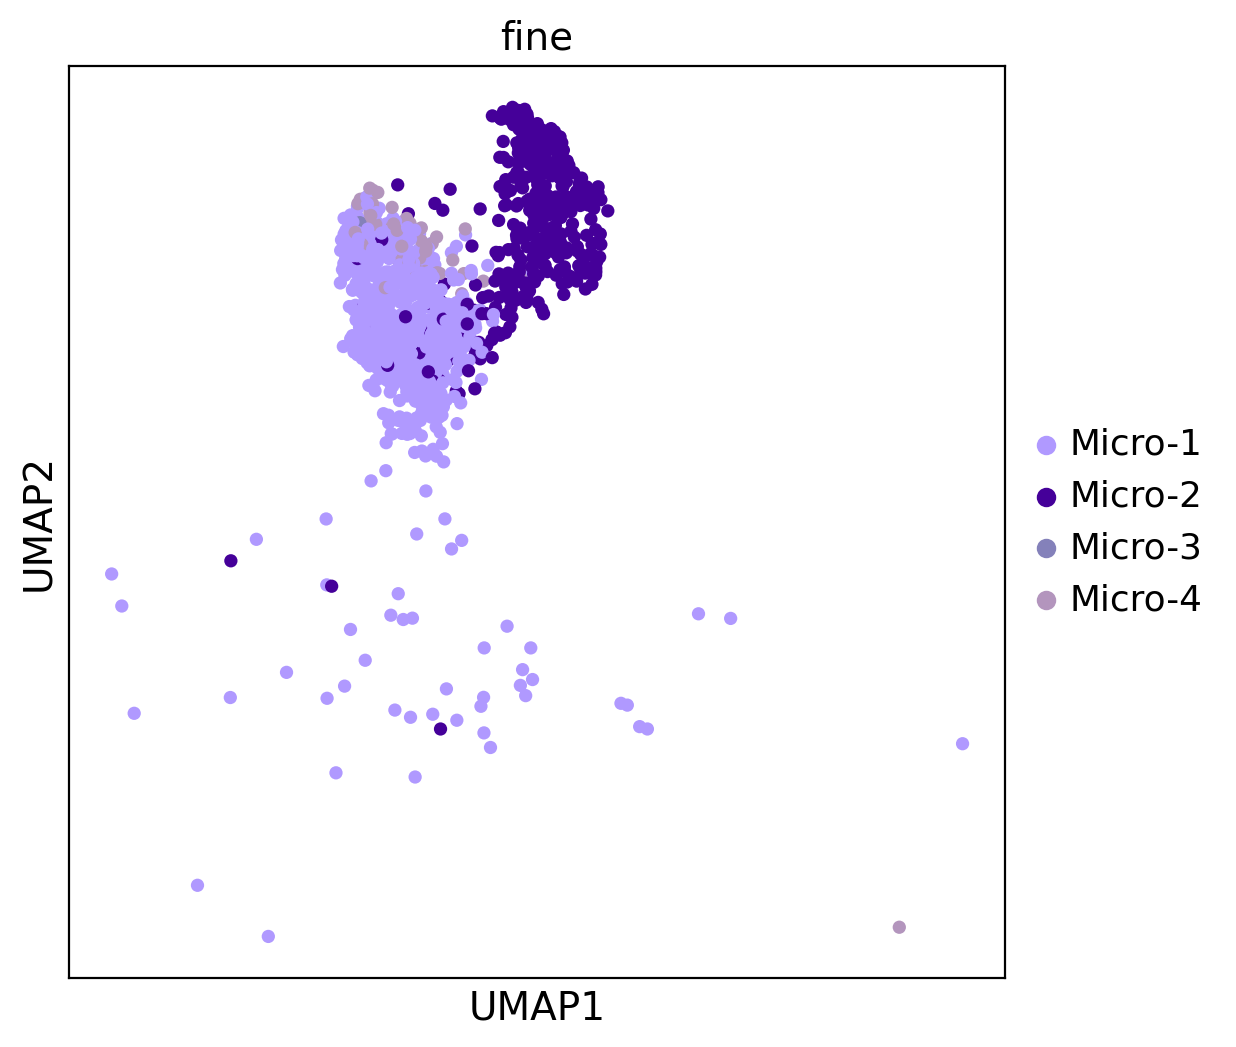

In [430]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
mask = (merge_adata.obs["datatype"] == "sn") & (merge_adata.obs["celltype"] == "Micro")
sc.pl.umap(merge_adata[mask], color = "fine", ax = ax, palette=cm.palettes.cell_type_colors)


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


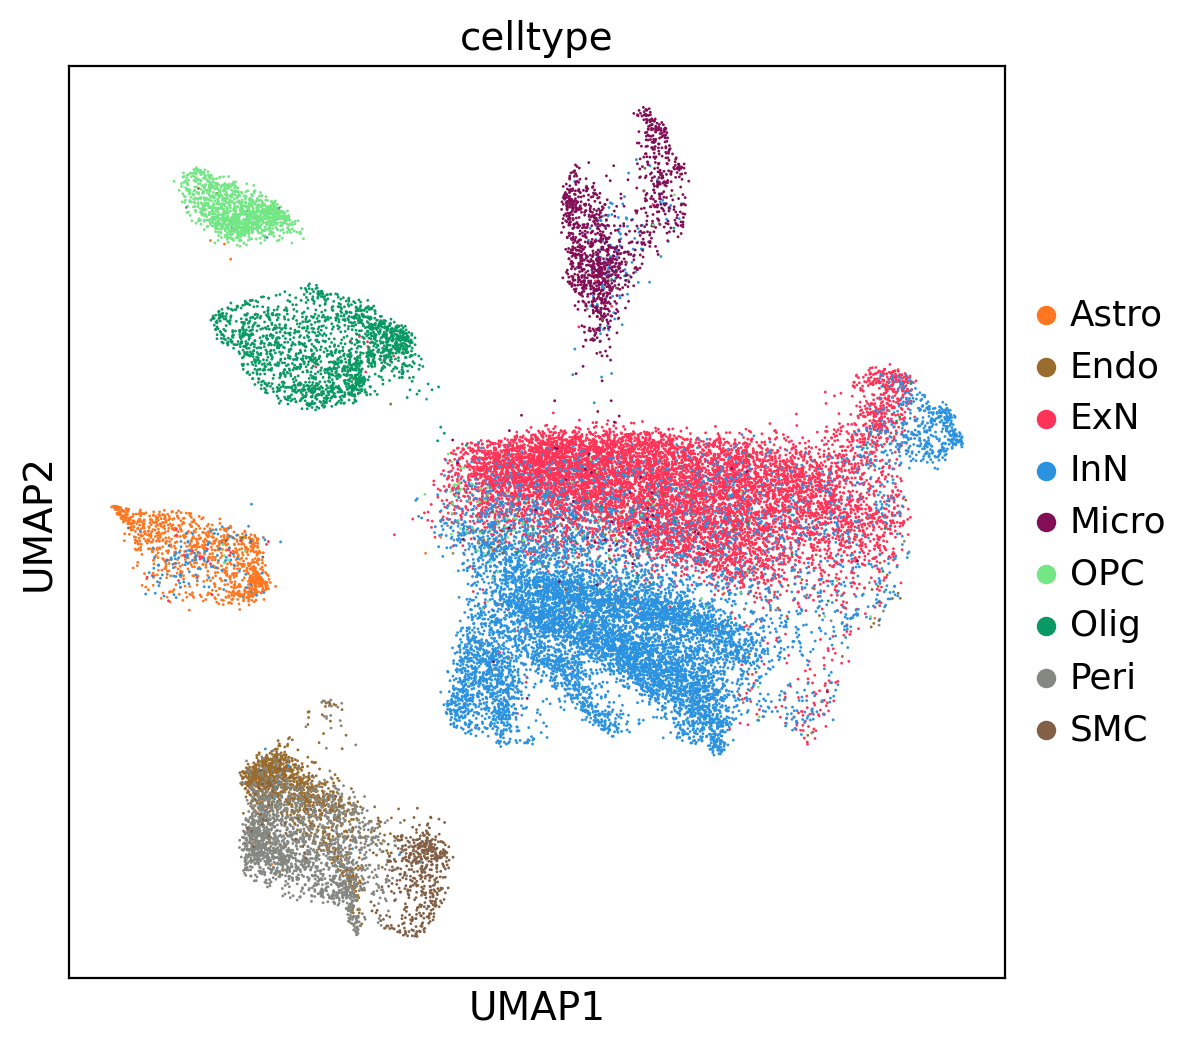

In [421]:
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
mask = (merge_adata.obs["datatype"] == "sn")
sc.pl.umap(merge_adata[mask], color = "celltype", ax = ax, palette=cm.palettes.general_type_colors)


## Use NeighborGraph

In [322]:
from sklearn.utils import check_random_state
from scipy.sparse import csr_matrix
from libpysal.weights import WSP
from esda.moran import Moran
from typing import List, Dict
from anndata import AnnData

def neighbor_compute_moran_i(sub_adata, value_key: str, category: str) -> dict:
    """
    Computes Moran's I spatial autocorrelation for a subset of cells.

    Args:
        sub_adata: Subset of AnnData object for specific cell type.
        value_key: The key in `sub_adata.obs` containing the values to analyze.
        category: The categorical variable in `sub_adata.obs` to group by.

    Returns:
        A dictionary with Moran's I results.
    """
    try:
        connectivities = sub_adata.obsp['connectivities']
    except KeyError:
        raise KeyError(f"Connectivity key 'connectivities' not found in sub_adata.obsp")

    weights = WSP(connectivities)
    values = sub_adata.obs[value_key].values
    weights_full = weights.to_W()
    moran = Moran(values, weights_full)
    return {
        category: sub_adata.obs[category].unique()[0],
        "Moran's I": moran.I,
        "P-value": moran.p_norm,
        "num_cell": len(values)
    }

def neighbor_process_cell_type(adata, cell_type: str, value_key: str, category: str) -> pd.DataFrame:
    """
    Processes a specific cell type to compute Moran's I.

    Args:
        adata: The AnnData object to analyze.
        cell_type: The specific cell type to process.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.

    Returns:
        A DataFrame with Moran's I results for the specific cell type.
    """
    mask = adata.obs[category] == cell_type
    num_cell = sum(mask)
    if num_cell > 10:
        sub_adata = adata[mask].copy()
        moranI_data = neighbor_compute_moran_i(sub_adata, value_key, category)
        return pd.DataFrame([moranI_data])
    return pd.DataFrame()

def compute_neighbor_moran_i_by_category(
    adata, 
    value_key: str, 
    category: str = "celltype", 
    connectivity_key: str = 'connectivities'
) -> pd.DataFrame:
    """
    Computes Moran's I spatial autocorrelation for each cell type.

    Args:
        adata: The AnnData object to analyze.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        connectivity_key: The key in `adata.obsp` containing the connectivities matrix.

    Returns:
        A DataFrame with Moran's I results for each cell type.
    """
    top_level_types = adata.obs[category].unique()
    result_df = pd.DataFrame()
    data_present = False
    
    for cell_type in top_level_types:
        cell_type_df = neighbor_process_cell_type(adata, cell_type, value_key, category)
        if not cell_type_df.empty:
            result_df = pd.concat([result_df, cell_type_df])
            data_present = True
    
    if not data_present:
        return pd.DataFrame()
    
    result_df = result_df.set_index(category)
    result_df = result_df.sort_values("Moran's I", ascending=False)
    return result_df

In [325]:
mask = merge_adata.obs["datatype"] == 'cellbin'
nei_df = compute_neighbor_moran_i_by_category(merge_adata[mask], "min_center_dist")

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 647 disconnected components.
 There are 544 islands with ids: 4, 7, 9, 15, 28, 33, 34, 44, 46, 48, 53, 55, 63, 66, 73, 82, 83, 84, 86, 88, 93, 96, 97, 100, 102, 104, 112, 114, 119, 124, 125, 128, 130, 138, 141, 143, 144, 158, 161, 173, 177, 183, 190, 192, 196, 203, 204, 213, 218, 221, 222, 226, 227, 237, 254, 258, 259, 261, 262, 263, 268, 271, 272, 275, 276, 280, 290, 292, 293, 298, 301, 302, 304, 317, 322, 328, 334, 344, 350, 352, 356, 359, 360, 365, 371, 378, 384, 389, 392, 393, 410, 411, 414, 417, 427, 429, 436, 442, 443, 445, 446, 447, 449, 451, 453, 454, 455, 458, 459, 461, 464, 485, 495, 496, 497, 498, 508, 517, 526, 527, 534, 540, 541, 552, 553, 558, 561, 565, 569, 579, 587, 591, 595, 596, 606, 607, 611, 612, 616, 617, 618, 620, 623, 624, 628, 632, 633, 636, 642, 643, 647, 661, 669, 670, 671, 672, 675, 677, 67

('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 48, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 63, ' is an island (no neighbors)')
('WARNING: ', 66, ' is an island (no neighbors)')
('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
('WARNING: ', 83, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 86, ' is an island (no neighbors)')
('WARNING: ', 88, ' is an island (no neighbors)')
('W

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 495 disconnected components.
 There are 423 islands with ids: 3, 4, 6, 7, 8, 10, 15, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31, 32, 34, 38, 39, 47, 49, 50, 51, 54, 55, 60, 61, 63, 65, 66, 68, 70, 71, 72, 73, 76, 77, 78, 80, 81, 82, 83, 85, 86, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 103, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 132, 135, 136, 137, 138, 140, 141, 142, 146, 148, 149, 155, 156, 159, 161, 162, 164, 165, 167, 169, 171, 172, 176, 177, 179, 181, 183, 184, 185, 187, 188, 189, 191, 192, 200, 203, 204, 207, 209, 210, 212, 213, 214, 215, 222, 223, 229, 231, 232, 233, 238, 240, 241, 245, 246, 251, 252, 254, 255, 260, 264, 265, 273, 274, 278, 279, 292, 293, 294, 295, 296, 306, 312, 313, 314, 316, 318, 319, 320, 321, 322, 329, 330, 333, 334, 348, 354, 356, 358, 3

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WAR

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 975 disconnected components.
 There are 825 islands with ids: 7, 11, 14, 15, 20, 22, 28, 32, 36, 37, 39, 40, 41, 44, 47, 52, 53, 61, 64, 67, 69, 73, 74, 75, 76, 77, 82, 84, 85, 88, 92, 93, 105, 109, 110, 111, 115, 116, 119, 120, 124, 125, 126, 134, 136, 137, 138, 148, 149, 154, 158, 159, 161, 162, 164, 165, 166, 167, 168, 169, 170, 174, 177, 179, 180, 181, 188, 191, 193, 195, 200, 215, 218, 219, 222, 225, 226, 227, 232, 233, 239, 244, 245, 246, 248, 250, 251, 253, 260, 265, 266, 271, 274, 275, 276, 279, 284, 287, 289, 290, 296, 297, 298, 300, 301, 305, 306, 309, 312, 313, 314, 317, 319, 320, 324, 326, 329, 332, 339, 341, 342, 343, 344, 350, 351, 353, 354, 355, 357, 367, 368, 369, 373, 374, 376, 380, 381, 383, 385, 388, 389, 390, 391, 393, 394, 402, 405, 407, 411, 413, 414, 418, 423, 426, 437, 439, 440, 441, 442, 443,

('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 41, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 64, ' is an island (no neighbors)')
('WARNING: ', 67, ' is an island (no neighbors)')
(

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 617 disconnected components.
 There are 532 islands with ids: 3, 5, 10, 11, 12, 16, 17, 19, 23, 30, 31, 32, 34, 36, 44, 47, 51, 52, 53, 54, 55, 58, 59, 60, 65, 67, 68, 74, 76, 80, 81, 82, 83, 87, 90, 94, 102, 103, 107, 112, 113, 114, 118, 119, 120, 121, 126, 127, 129, 133, 135, 137, 138, 140, 143, 145, 147, 150, 151, 153, 156, 157, 160, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 190, 193, 194, 195, 197, 198, 199, 204, 210, 214, 216, 220, 222, 226, 228, 229, 231, 233, 234, 235, 236, 238, 239, 241, 243, 245, 246, 247, 248, 252, 254, 255, 259, 261, 262, 263, 264, 267, 268, 270, 273, 275, 276, 278, 285, 286, 287, 290, 292, 293, 297, 298, 299, 300, 301, 303, 304, 307, 308, 310, 311, 312, 314, 315, 316, 318, 320, 327, 329, 330, 331, 334, 335, 340, 343, 344, 345, 346,

('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 48, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 95, ' is an island (no neighbors)')
('WARNING: ', 98, ' is an island (no neighbors)')
('WARNING: ', 103, ' is an island (no neighbors)')
('WARNING: ', 111, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 152, ' is an island (no neighbors)')
('WARNING: ', 175, ' is an island (no neighbors)')
('WARNING: ', 179, ' is an island (no neighbors)')
('WARNING: ', 181, ' is an island (no neighbors)')
('WARNING: ', 193, ' is an island (no neighbors)')
('WARNING: ', 200, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
('WARNING: ', 253, ' is an island (no neighbors)')
('WARNING: ', 255, ' is an island (no neighbors)')
('WARNING: ', 257, ' is an island (no n

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 888 disconnected components.
 There are 768 islands with ids: 0, 1, 2, 7, 10, 22, 25, 28, 29, 36, 38, 46, 51, 53, 57, 58, 59, 64, 80, 84, 97, 105, 112, 113, 121, 126, 134, 143, 145, 146, 149, 154, 167, 168, 178, 179, 183, 186, 189, 190, 192, 194, 195, 198, 207, 210, 221, 233, 236, 248, 249, 261, 265, 268, 280, 281, 285, 296, 299, 300, 301, 302, 303, 308, 312, 316, 317, 322, 326, 339, 340, 350, 351, 356, 361, 369, 373, 374, 380, 381, 391, 393, 399, 407, 408, 415, 420, 421, 431, 441, 442, 445, 457, 459, 465, 486, 509, 511, 516, 517, 520, 530, 542, 543, 544, 553, 570, 575, 577, 578, 581, 584, 585, 587, 588, 594, 595, 600, 604, 612, 613, 616, 622, 625, 627, 634, 637, 641, 643, 647, 652, 673, 677, 684, 686, 691, 692, 697, 699, 701, 704, 709, 711, 720, 721, 722, 727, 730, 732, 737, 738, 739, 753, 758, 771, 785, 791, 798, 8

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 29, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 64, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WA

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 265 disconnected components.
 There are 248 islands with ids: 20, 39, 41, 152, 185, 240, 295, 508, 551, 561, 667, 670, 812, 818, 836, 842, 1091, 1373, 1402, 1414, 1520, 1718, 1965, 2060, 2079, 2152, 2208, 2370, 2379, 2439, 2549, 2616, 2848, 2861, 2882, 2890, 2984, 2987, 3301, 3356, 3379, 3572, 3583, 3632, 3633, 3636, 3682, 3708, 3866, 3996, 4071, 4283, 4407, 4536, 4630, 4672, 4725, 4733, 4905, 4931, 4978, 4987, 5044, 5254, 5516, 5540, 5588, 5637, 5649, 5913, 5948, 6218, 6338, 6382, 6414, 6473, 6608, 6720, 6732, 6752, 6815, 6859, 6953, 7020, 7048, 7065, 7200, 7356, 7473, 7550, 7682, 7756, 8050, 8153, 8253, 8414, 8634, 8806, 8878, 8914, 8961, 8984, 9091, 9129, 9402, 9435, 9454, 9770, 9833, 9936, 9942, 9946, 10004, 10030, 10215, 10226, 10603, 10709, 10778, 10801, 10912, 11007, 11459, 11798, 11912, 11934, 11952, 11997, 1

('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 41, ' is an island (no neighbors)')
('WARNING: ', 152, ' is an island (no neighbors)')
('WARNING: ', 185, ' is an island (no neighbors)')
('WARNING: ', 240, ' is an island (no neighbors)')
('WARNING: ', 295, ' is an island (no neighbors)')
('WARNING: ', 508, ' is an island (no neighbors)')
('WARNING: ', 551, ' is an island (no neighbors)')
('WARNING: ', 561, ' is an island (no neighbors)')
('WARNING: ', 667, ' is an island (no neighbors)')
('WARNING: ', 670, ' is an island (no neighbors)')
('WARNING: ', 812, ' is an island (no neighbors)')
('WARNING: ', 818, ' is an island (no neighbors)')
('WARNING: ', 836, ' is an island (no neighbors)')
('WARNING: ', 842, ' is an island (no neighbors)')
('WARNING: ', 1091, ' is an island (no neighbors)')
('WARNING: ', 1373, ' is an island (no neighbors)')
('WARNING: ', 1402, ' is an island (no neighbors)')
('WARNING: ', 1414, ' is an isl

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 1331 disconnected components.
 There are 1181 islands with ids: 6, 8, 16, 19, 30, 38, 39, 49, 51, 54, 59, 63, 68, 70, 71, 75, 78, 91, 103, 112, 116, 124, 131, 139, 153, 158, 159, 172, 183, 187, 192, 196, 203, 210, 216, 221, 237, 239, 247, 254, 256, 257, 259, 266, 270, 271, 272, 276, 282, 284, 286, 287, 289, 299, 305, 307, 308, 312, 314, 319, 326, 327, 329, 335, 343, 356, 358, 359, 361, 369, 371, 380, 390, 401, 404, 408, 417, 419, 430, 434, 435, 436, 442, 450, 453, 457, 470, 472, 481, 491, 492, 510, 521, 523, 526, 528, 534, 538, 540, 541, 545, 546, 548, 549, 550, 551, 558, 559, 570, 575, 581, 582, 586, 594, 602, 606, 624, 625, 635, 647, 648, 650, 655, 659, 660, 667, 670, 675, 687, 693, 702, 708, 713, 722, 733, 749, 761, 775, 790, 795, 797, 811, 835, 843, 855, 856, 868, 875, 876, 889, 892, 903, 904, 917, 920, 927, 928,

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 54, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 63, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 70, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 91, ' is an island (no neighbors)')
('WARNING: ', 103, ' is an island (no neighbors)')
('WARNING: ', 112, ' is an island (no neighbors)')


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 458 disconnected components.
 There are 403 islands with ids: 4, 5, 6, 8, 10, 13, 14, 15, 17, 18, 20, 21, 22, 23, 25, 26, 29, 31, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 67, 69, 70, 71, 73, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96, 97, 98, 99, 102, 103, 105, 106, 107, 108, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 130, 131, 132, 134, 136, 138, 140, 143, 144, 145, 146, 148, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 173, 175, 176, 179, 181, 182, 183, 184, 185, 187, 189, 190, 191, 192, 194, 196, 197, 198, 199, 201, 203, 204, 205, 206, 208, 209, 210, 212, 214, 216, 217, 218, 220, 221, 222, 223, 226, 227, 228, 230, 231, 233, 234, 235, 236, 238, 240, 241, 242, 243, 244

In [326]:
nei_df

Moran's I        P-value  num_cell
celltype                                    
SMC        0.537175   1.161472e-28      1028
Endo       0.201083   1.447310e-05       909
Micro      0.199453   9.742282e-22      2403
Peri       0.175543   1.068591e-08      2089
Olig       0.170371   8.768067e-26      3877
Astro      0.149629   5.841299e-36      5664
ExN        0.137300  1.701727e-215     23274
InN        0.090740   1.808333e-15      7838
OPC        0.050444   5.640592e-01       591
MSN       -0.184052   8.865775e-01        22